In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
%matplotlib inline

In [2]:
# !pip install -U scikit-learn

## Importing data

In [51]:
dataset=pd.read_excel('April_24_cor.xlsx')
dataset.head()

Folder                                          ImageName  PlantID  \
0  April_24_2023  images\VINIR Camera_April_24_2023\VINIR_ROW1_2...        1   
1  April_24_2023  images\VINIR Camera_April_24_2023\VINIR_ROW1_2...        2   
2  April_24_2023  images\VINIR Camera_April_24_2023\VINIR_ROW1_2...        3   
3  April_24_2023  images\VINIR Camera_April_24_2023\VINIR_ROW1_2...        4   
4  April_24_2023  images\VINIR Camera_April_24_2023\VINIR_ROW1_2...        5   

     Area  MajorAxisLength  MinorAxisLength    Perimeter  ConvexArea  \
0   42102       580.242859       203.698044  5224.882812       97824   
1  130899       890.145691       214.054276  4198.558105      181573   
2  139212      1039.285767       191.293640  4397.378906      184854   
3  104656      1099.419922       150.436371  4010.205078      137721   
4  108607      1060.576294       146.787125  4620.351074      130456   

   Eccentricity      NDVI  ...       988       990       991       992  \
0      0.936354  0.091480  ...  0.033444  0.035009  0.034485  0.035024   
1      0.970656  0.365892  ...  0.261564  0.263534  0.264266  0.265175   
2      0.982915  0.473241  ...  0.292496  0.296032  0.296148  0.296767   
3      0.990594  0.578414  ...  0.458008  0.461111  0.461111  0.461175   
4      0.990376  0.620946  ...  0.461876  0.465081  0.465859  0.466264   

        994       995       997       998       999      1001  
0  0.035341  0.034869  0.033141  0.033134  0.033149  0.033141  
1  0.264615  0.263544  0.259655  0.259635  0.259625  0.259722  
2  0.294819  0.294122  0.290676  0.290654  0.290646  0.290714  
3  0.459267  0.458136  0.453003  0.452964  0.452887  0.452894  
4  0.466424  0.465358  0.461426  0.461439  0.461439  0.461400  

[5 rows x 479 columns]

In [53]:
#dataset.set_index("Unnamed: 0",inplace=True)
#gt=dataset.iloc[:,-13:]
#dataset.columns = dataset.iloc[0]

reflec=dataset.iloc[:,31:]
#reflec.columns=reflec.columns.astype('int')
reflec.head()

0  0.150993  0.151023  0.155378  0.155238  0.152351  0.145434  0.134788  \
0  0.150993  0.151023  0.155378  0.155238  0.152351  0.145434  0.134788   
1  0.077125  0.077252  0.078961  0.078910  0.076907  0.072541  0.067816   
2  0.171492  0.172615  0.186489  0.191811  0.190223  0.183155  0.172391   
3  0.130384  0.130673  0.139578  0.143677  0.142951  0.138916  0.131213   
4  0.078838  0.079583  0.086599  0.089490  0.089355  0.086683  0.081633   

0  0.122200  0.107737  0.091945  ...  0.033444  0.035009  0.034485  0.035024  \
0  0.122200  0.107737  0.091945  ...  0.033444  0.035009  0.034485  0.035024   
1  0.062651  0.056620  0.050379  ...  0.261564  0.263534  0.264266  0.265175   
2  0.159730  0.145736  0.126932  ...  0.292496  0.296032  0.296148  0.296767   
3  0.121678  0.110525  0.096474  ...  0.458008  0.461111  0.461111  0.461175   
4  0.074726  0.067807  0.058716  ...  0.461876  0.465081  0.465859  0.466264   

0  0.035341  0.034869  0.033141  0.033134  0.033149  0.033141  
0  0.035341  0.034869  0.033141  0.033134  0.033149  0.033141  
1  0.264615  0.263544  0.259655  0.259635  0.259625  0.259722  
2  0.294819  0.294122  0.290676  0.290654  0.290646  0.290714  
3  0.459267  0.458136  0.453003  0.452964  0.452887  0.452894  
4  0.466424  0.465358  0.461426  0.461439  0.461439  0.461400  

[5 rows x 448 columns]

### viz

Text(0, 0.5, 'Reflectance')

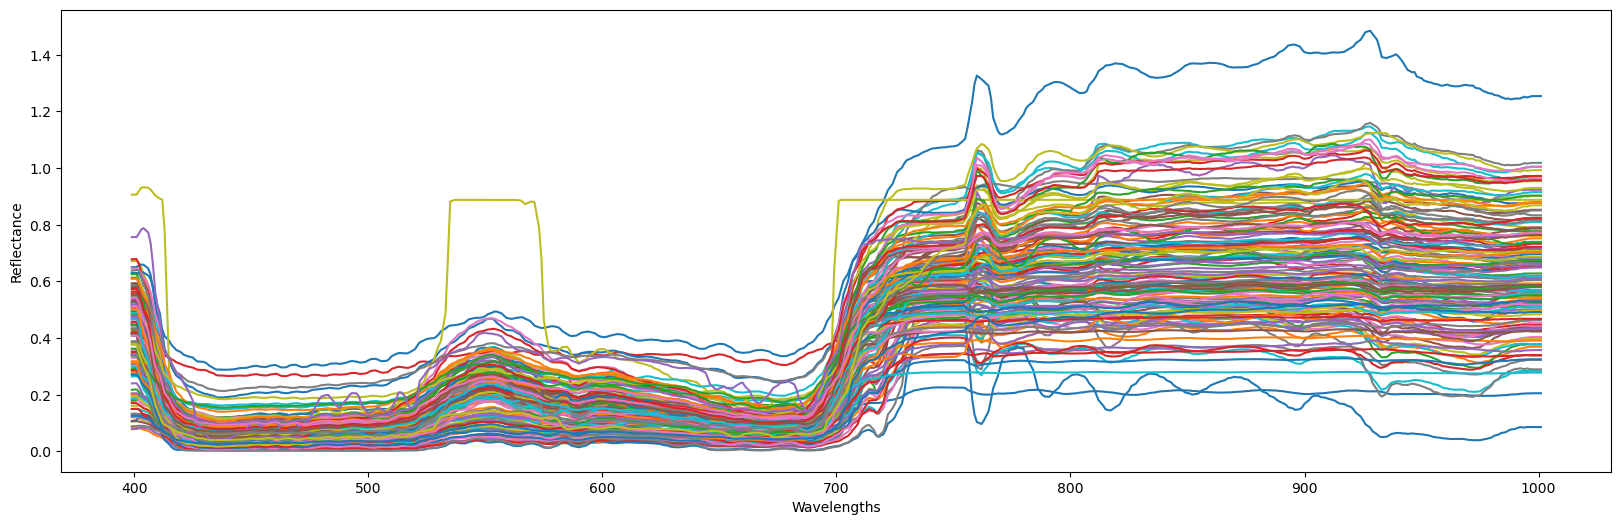

In [21]:
ax=reflec.iloc[:,:].T.plot(figsize=(20,6),legend=False)
ax.set_xlabel("Wavelengths")
ax.set_ylabel('Reflectance')

## SNR

In [42]:
def snr(spectral):
    mean_s=np.mean(spectral)
    std_s=np.std(spectral)
    return np.where(std_s==0,0,mean_s/std_s)

def find_range(spectral,wavelengths,win):
    n=spectral.shape[0]
    snr_value=np.zeros(n-win+1)
    for i in range(n-win+1):
        snr_value[i]=snr(spectral[i:i+win])
        
    optimal_start=wavelengths[np.argmax(snr_value)]
    optimal_end=optimal_start+win
    return optimal_start, optimal_end,max(snr_value)



def optimum_range(win_size):
    dic={'s':[],'e':[],'v':[]}
    for i in range(reflec.shape[0]):
        
        s,e,v=find_range(reflec.iloc[i,:],reflec.columns.values.astype('int'),win_size)
        dic['s'].append(s)
        dic['e'].append(e)
        dic['v'].append(v)
    df=pd.DataFrame.from_dict(dic).describe()
 
    print(f'For window size {win_size}\n min start and end {df.iloc[3,0:2].values} with SNR {df.iloc[3,2]} \n max start and end {df.iloc[-1,0:2].values} \n............\n')



In [43]:
np.random.seed(100)
win_size=np.squeeze(np.random.rand(1,20)*100).astype('int')
win_size

array([54, 27, 42, 84,  0, 12, 67, 82, 13, 57, 89, 20, 18, 10, 21, 97, 81,
       17, 81, 27])

In [46]:
win_size=[reflec.shape[1],reflec.shape[1]-50,reflec.shape[1]-200]
win_size

[448, 398, 248]

In [47]:
for i in win_size:
    optimum_range(i)

For window size 448
 min start and end [399. 847.] with SNR 0.8414242449389222 
 max start and end [399. 847.] 
............

For window size 398
 min start and end [463. 861.] with SNR 0.8929442850727196 
 max start and end [463. 861.] 
............

For window size 248
 min start and end [399. 647.] with SNR 1.3193746796202832 
 max start and end [663. 911.] 
............



In [48]:
def viz(value,title):
    ax=value.T.plot(figsize=(20,6),legend=False)
    ax.set_xlabel("Wavelengths")
    ax.set_ylabel('Reflectance')
    ax.set_title(title)

### 1951

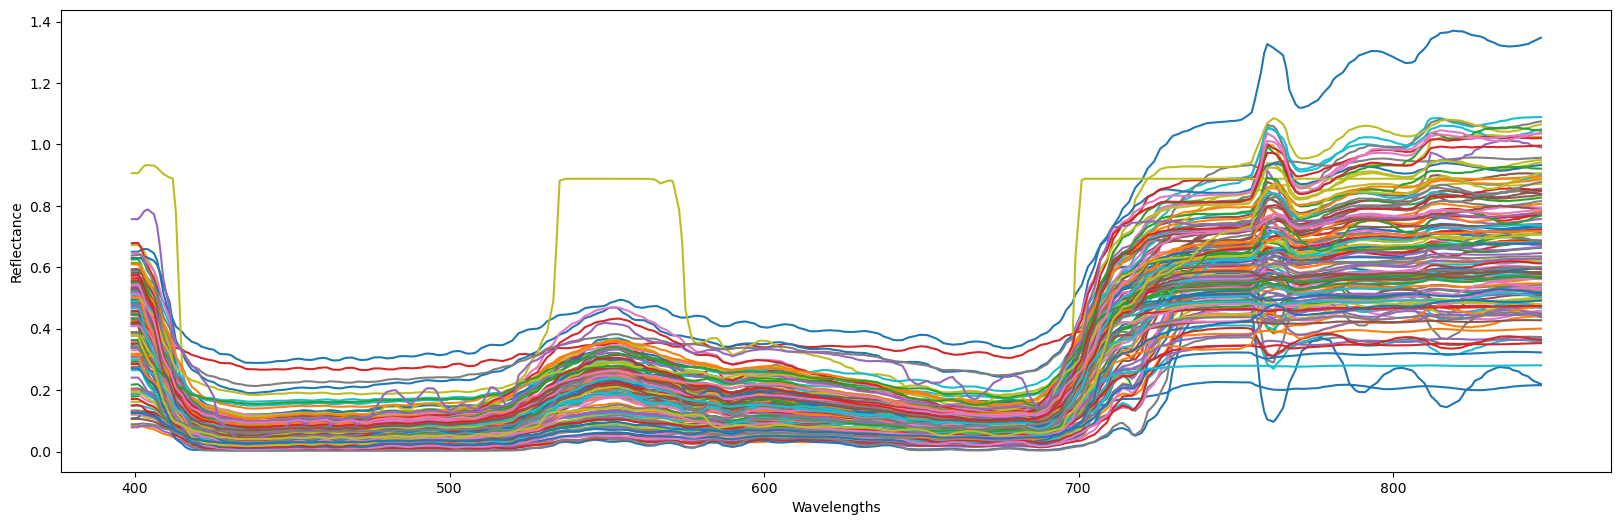

In [50]:
viz(reflec.loc[:,399: 847],'')

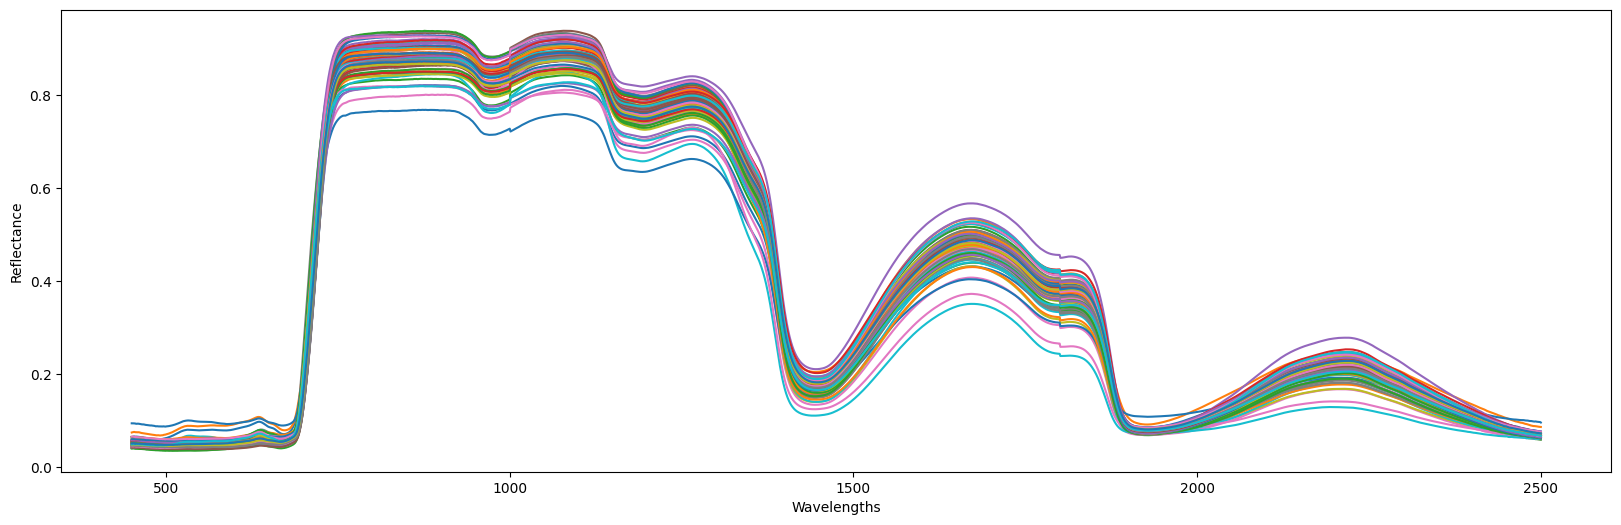

In [11]:
viz(reflec.loc[:, 450:2500],'')

## 1851

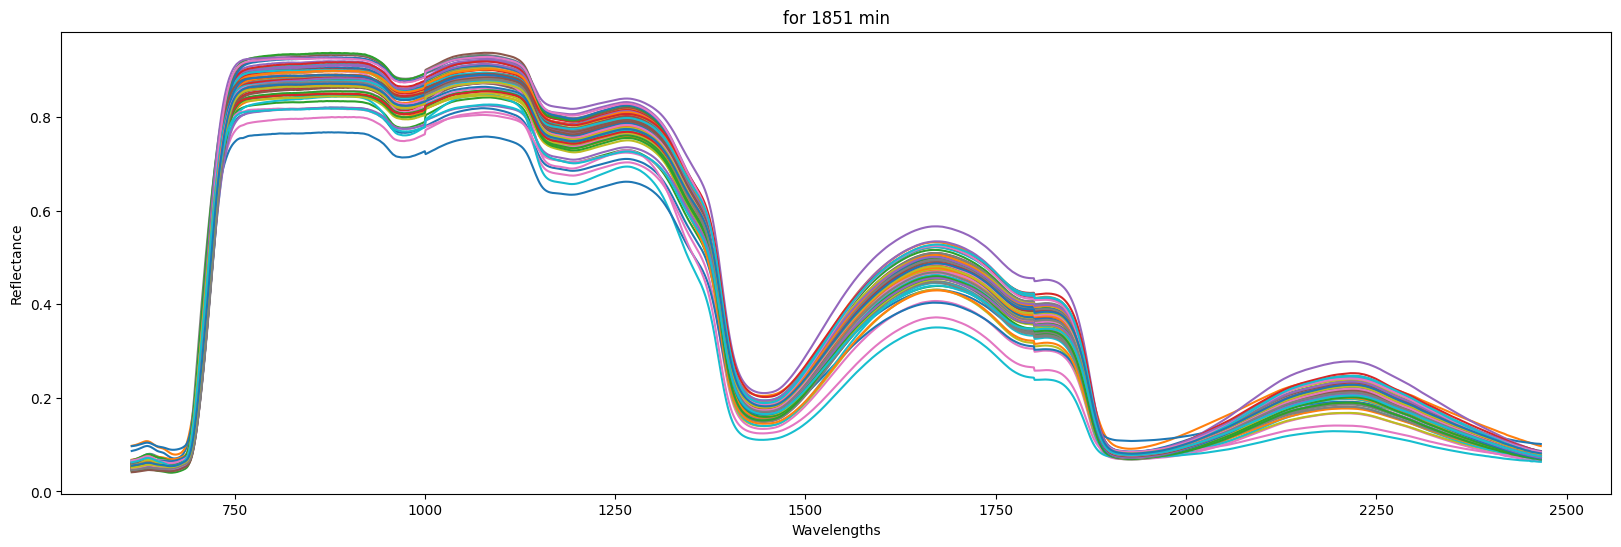

In [11]:
viz(reflec.loc[:,615:2466],'for 1851 min')

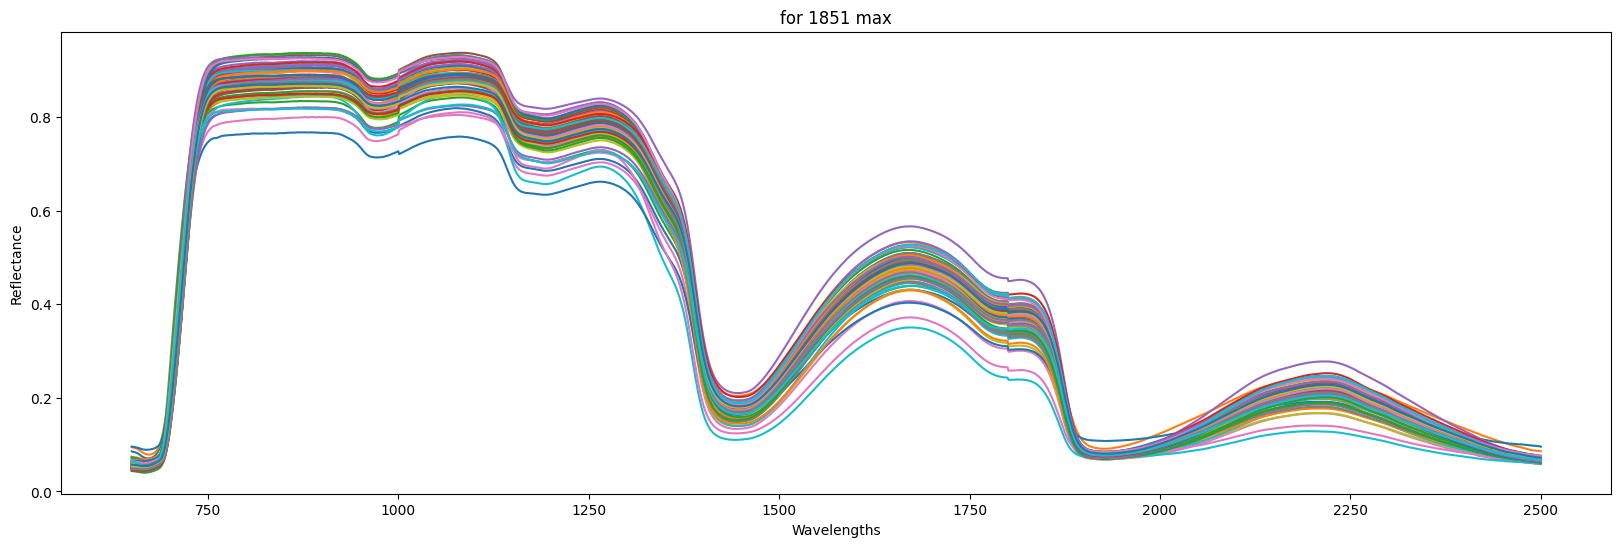

In [12]:
viz(reflec.loc[:,650:],'for 1851 max')

## Preprocessing

1. log(1/r) transformation- absorbance
2. mean scatter correction 
3. mean- center scaling - SNV

In [10]:
def transformation(r):
    return np.log(1/r)

def mean_center(data):
    new=data.copy()
    for i in range(data.shape[0]):
         new.iloc[i,:]= (data.iloc[i,:]-np.mean(data.iloc[i,:]))
    return new
        
def msc(input_data,reference=None):
    eps=np.finfo(np.float32).eps
    input_=np.array(input_data,dtype=np.float64)
    ref=[]
    sampleCount=int(len(input_))
    for i in range(.shape[0]):
        input_[i,:]-=input_[i,:].mean()
    data_msc=input_data.copy()
    for i in range(input_.shape[0]):
        for j in range(0,sampleCount,10):
            ref.append(np.mean(input_[j:j+10],axis=0))
            fit=np.polyfit(ref[i],input_[i,:],1,full=True)
            data_msc.iloc[i,:]=(input_[i,:]-fit[0][1])/fit[0][0]
    
    return (data_msc)

In [14]:
reflec.shape

(71, 2151)

In [77]:
x_1=transformation(reflec.loc[:,450:2475])
x_2=msc(x_1)
x_3=mean_center(x_2)


<AxesSubplot: >

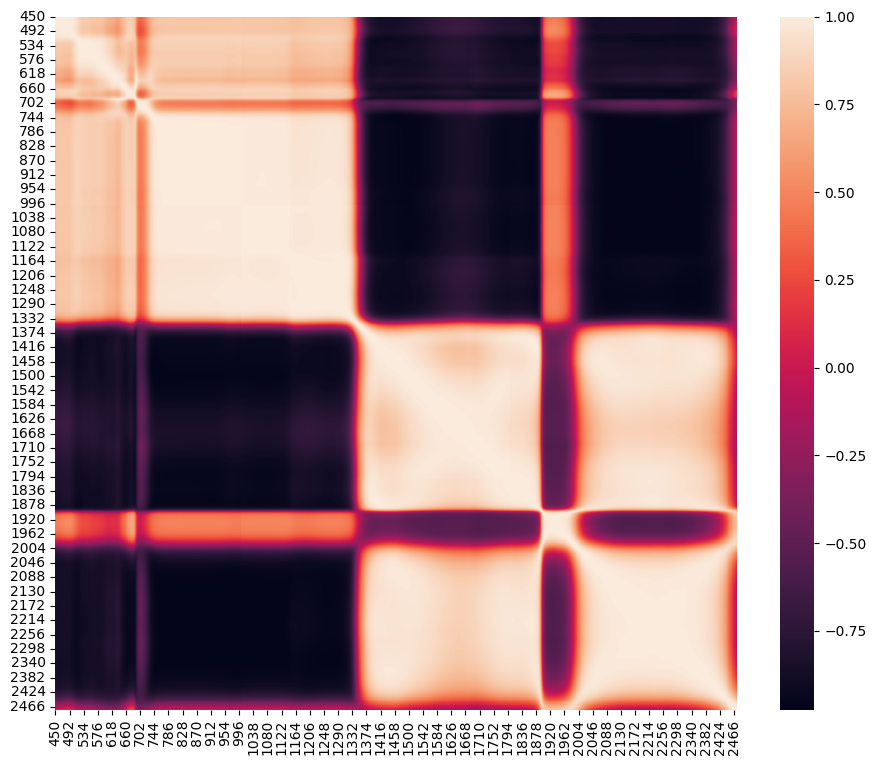

In [78]:
import seaborn as sns
corr=x_3.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr)

Text(0.5, 1.0, 'preprocessed')

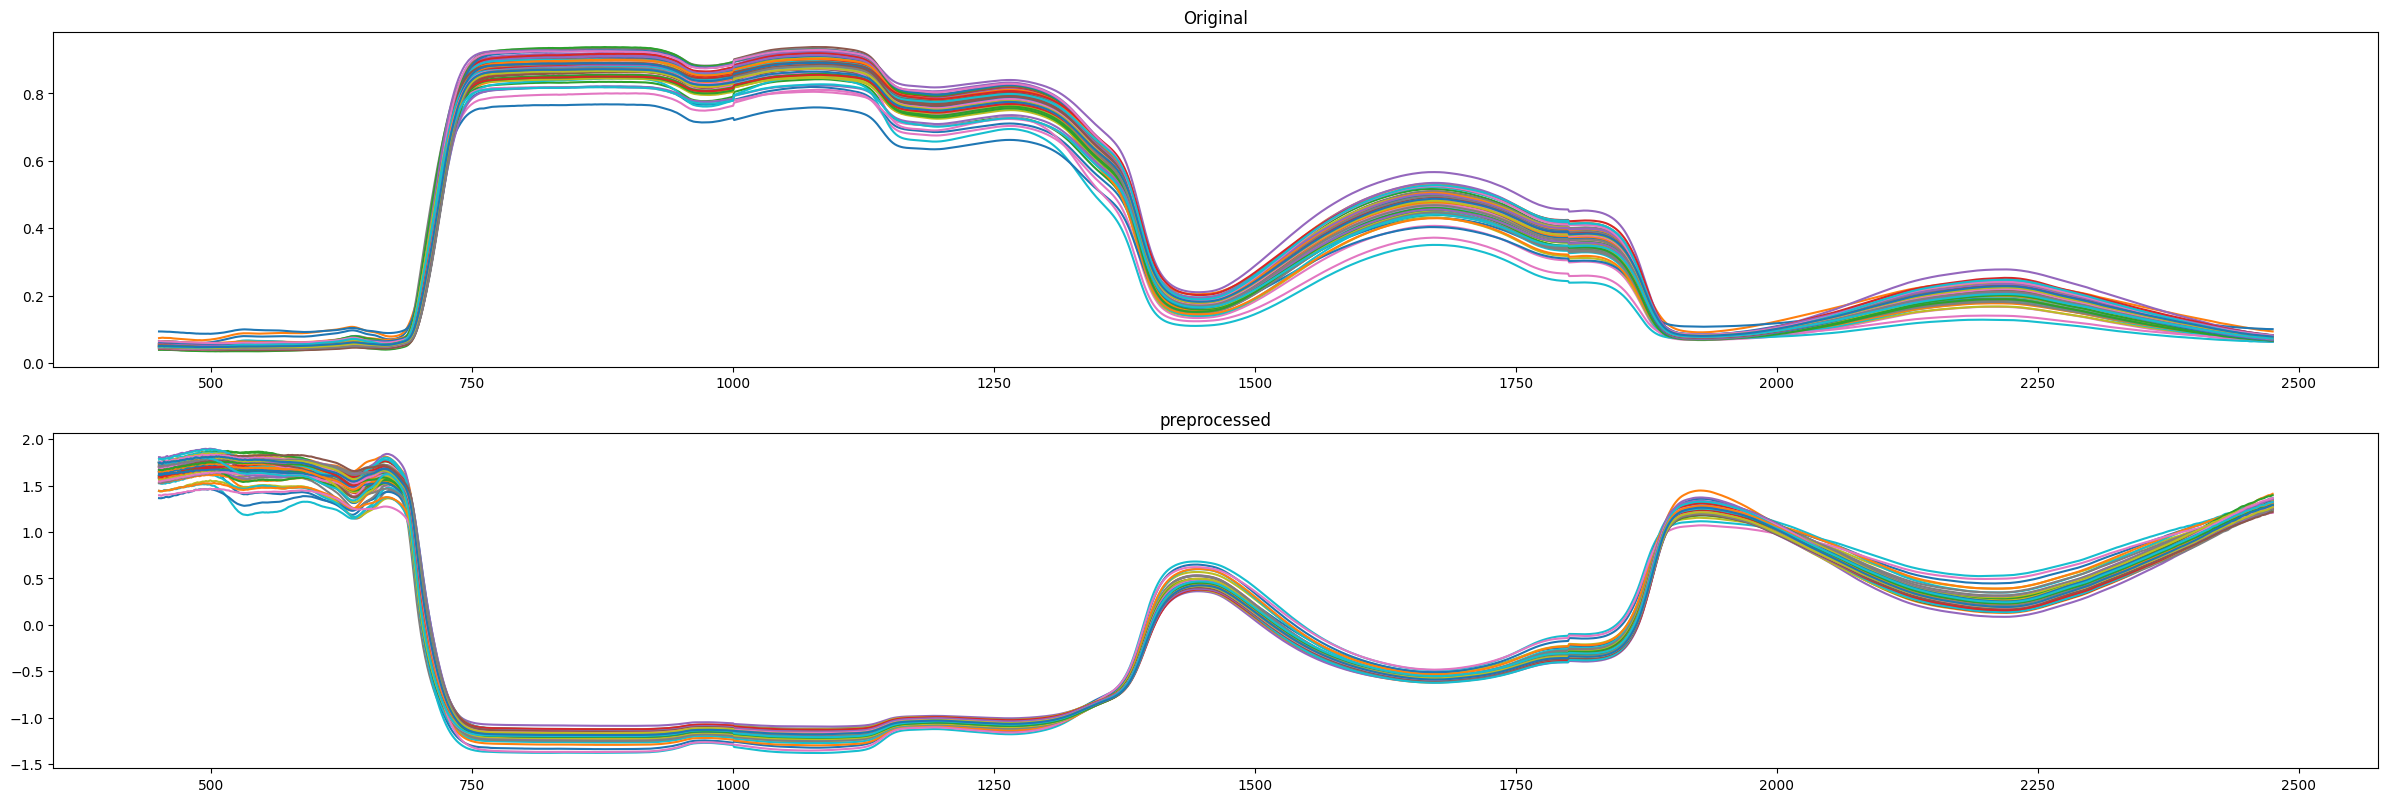

In [80]:
plt.figure(figsize=(30,20))

ax1 = plt.subplot(411)
reflec.loc[:,450:2475].T.plot(ax=ax1,legend=False)
ax1.set_title('Original')
    
ax2=plt.subplot(412)
x_3.T.plot(ax=ax2,legend=False)
ax2.set_title('preprocessed')
    

##  l

1. SNR value, transformation and SNV, transformation-SNV
2. model LR,PLSR, SVR, PCR , RF and ensemble (1 vs all)
3. cross validation
4. apply those on not processed dataset
 


In [81]:
#training set for sequential preprocessing
#xs_train_1951=x_3.loc[:,524 :2475]
#x_train_whole=x_3.loc[:, 450 : 2466]
#changed
xs_train_1951=x_3
standardGT = gt.copy()
standardGT.drop(columns='Cl (%)',inplace=True)

X1_train, X1_test, y1_train, y1_test = train_test_split(xs_train_1951, standardGT, test_size=0.2, random_state=42)

#X2_train, X2_test, y2_train, y2_test = train_test_split(x_train_whole, standardGT, test_size=0.2, random_state=42)

def caliberate(ytrain,ytest):
    '''
    input: target value of train and test
    
    output: standardized train and test 
    '''
    s={}
    target_col=ytrain.columns
    for col in target_col:
        s[col]=StandardScaler()
        ytrain.loc[:,col]=s[col].fit_transform(ytrain.loc[:,col].values.reshape(-1,1))
        ytest.loc[:,col]=s[col].transform(ytest.loc[:,col].values.reshape(-1,1))
    return s,ytrain,ytest

scalers_1,y1_train, y1_test=caliberate(y1_train, y1_test)
#scalers_2,y2_train, y2_test=caliberate(y2_train, y2_test)

In [82]:
def rpd(true,pred):
    deviation= pred-true
    ration =(true/pred) *100
    
    return ratio, deviation

## RPD=SD/RMSE

### Visualization function

In [83]:
def visualization(ytrain,y_cv,y_test,pred,cv_rms,cv_rs,pre_rms,pre_rs,scalers):
    
    plt.figure(figsize=(30,15))

    
    for i,val in enumerate(y_cv.keys()):
        if i==12:
            break
        #transforming to original value
        cv=scalers[val].inverse_transform(y_cv[val].reshape(-1,1))
        y1=scalers[val].inverse_transform(ytrain[val].values.reshape(-1,1))
        y1_t=scalers[val].inverse_transform(y_test[val].values.reshape(-1,1))
        pre=scalers[val].inverse_transform(pred[val].reshape(-1,1))
        
        z=np.polyfit(y1.reshape(-1),cv,1)
        plt.subplot(3,4,i+1)
        plt.plot(y1,z[1]+z[0]*y1,c='dimgray',linewidth=1)
        
        plt.scatter(y1,cv, c='mediumblue', label='CV: rmse={:0.3f} & r^2={:0.3f}'.format(cv_rms[val],cv_rs[val]))

#         plt.scatter(y1_t,pre, c='coral',label='Pred: rmse={:0.3f} & r^2={:0.3f}'.format(pre_rms[val],pre_rs[val]),
#                      edgecolors='purple')
        plt.xlabel(f"True {val}")
        plt.ylabel(f"Predicted {val}")
        plt.legend(loc=0,shadow=True,handletextpad=0.3,borderpad=0.3,handlelength=1)
    plt.show()

### Linear Regression

In [84]:
def lr(dfx,dftarget):
    
    '''
    input: trainset,testset
    output: RMSE,R^2, Cross validation prediction, models
    '''
    scores_rmse={}
    scores_rs={}
    if type(dfx)=='pandas.core.frame.DataFrame':
        x=dfx.values
    else:
        x=dfx
    models={}
    pred={}
    for target in dftarget.columns:
        models[target]=LinearRegression()
        models[target].fit(x,dftarget[target])
        pred[target]=cross_val_predict(models[target],x,dftarget[target],cv=5)
        scores_rmse[target]=mean_squared_error(dftarget[target].values, pred[target],squared=False)
        scores_rs[target]=models[target].score(x,dftarget[target])
        
    models['combine']=LinearRegression()
    models['combine'].fit(x,dftarget.values)
    pred['combine']=cross_val_predict(models[target],x,dftarget.values,cv=5)
    scores_rmse['combine']=mean_squared_error(dftarget.values,pred['combine'],squared=False)
    scores_rs['combine']=models['combine'].score(x,dftarget)

    return scores_rmse,scores_rs,pred, models

def pred(model,dfx,y):
    scores_rmse={}
    scores_rs={}
    pred={}
#     if type(dfx)=='pandas.core.frame.DataFrame':
#         x=dfx.values
#     else:
#         x=dfx
    for target in y.columns:
        pred[target]=model[target].predict(dfx)
        scores_rmse[target]=mean_squared_error(y[target].values,pred[target],squared=False)
        scores_rs[target]=model[target].score(dfx,y[target])
    if 'combine' in model.keys():
        pred['combine']=model['combine'].predict(dfx)
        scores_rmse['combine']=mean_squared_error(y,pred['combine'],squared=False)
        scores_rs['combine']=model['combine'].score(dfx,y)
    return scores_rmse,scores_rs,pred


In [85]:
LrCvScoreRmse1951,LrCvRs1951,LrPreCv1951,LrModel1951=lr(X1_train,y1_train)
#LrCvScoreRmse,LrCvRs,LrPreCv,LrModels=lr(X2_train,y2_train)

LrPreScoreRmse1951,LrPreScoreRs1951,LrPred1951=pred(LrModel1951,X1_test,y1_test)
#LrPreScoreRmse,LrPreScoreRs,LrPred=pred(LrModels,X2_test,y2_test)

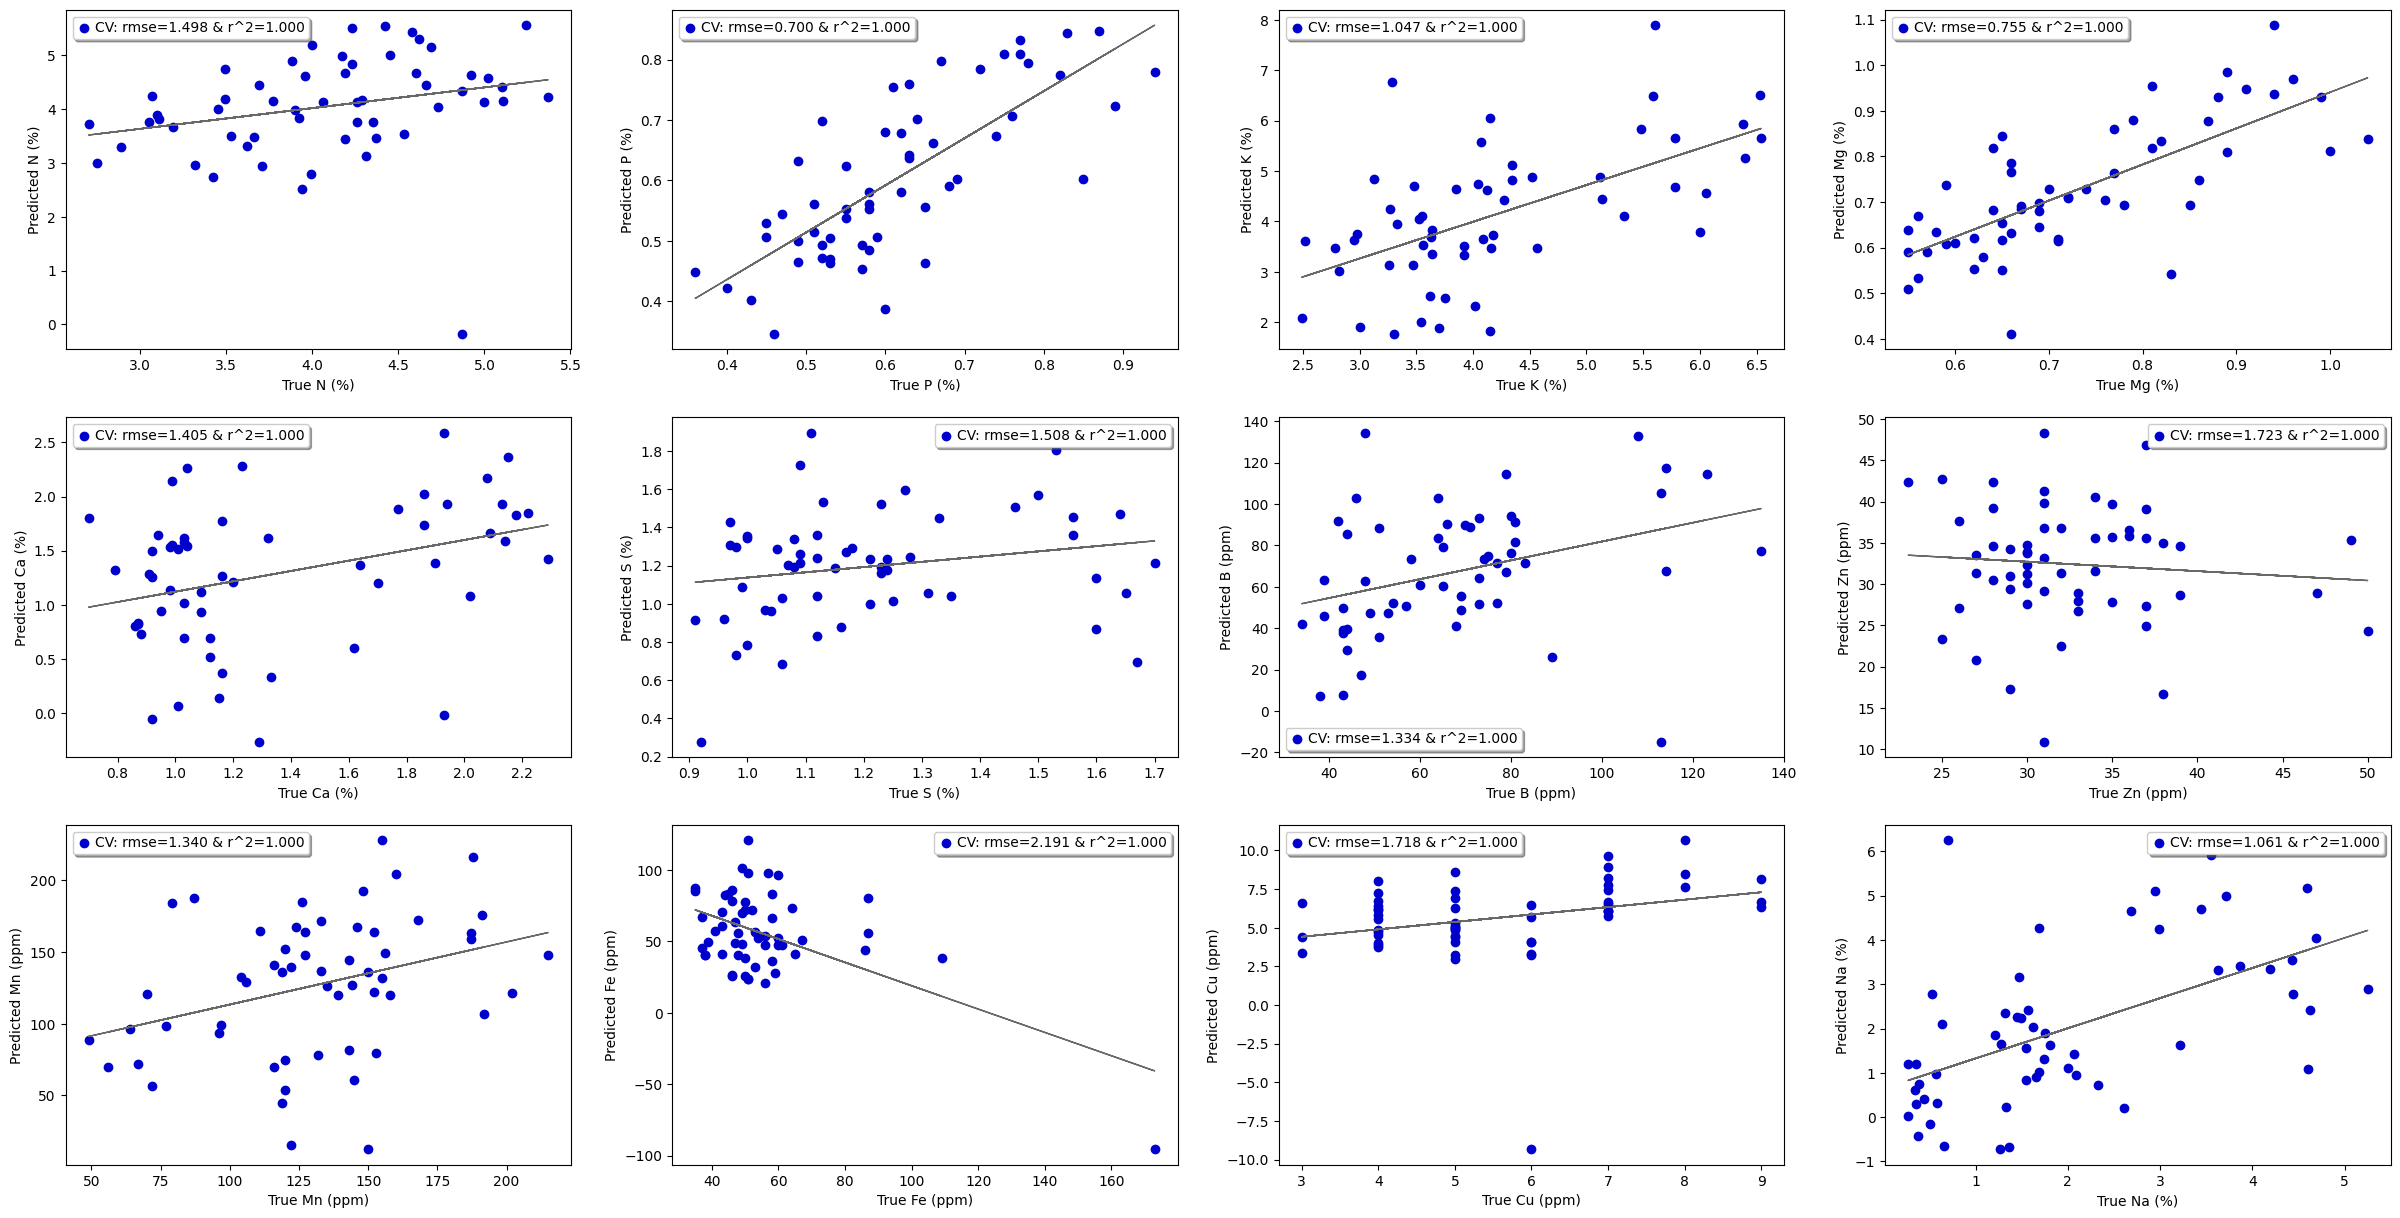

In [86]:
visualization(y1_train,LrPreCv1951,y1_test,LrPred1951,
              LrCvScoreRmse1951,LrCvRs1951,
              LrPreScoreRmse1951,LrPreScoreRs1951,scalers_1)

### PLSR

In [88]:
def find_com(n_com,X,y):
    mse=[]
    comp=np.arange(1,n_com)
    for i in comp:
        pls=PLSRegression(n_components=i)
        y_cv=cross_val_predict(pls,X,y,cv=5)
        mse.append(mean_squared_error(y,y_cv,squared=False))

    return np.argmin(mse)

def PLSR(dfx,dftarget,component):
    scores_rmse={}
    scores_rs={}
    pred={}
    models={}
    compo=[]
    x=dfx.values
    for target in dftarget.columns:
        com=find_com(component,dfx.values,dftarget[target])
        print(f'For {target} the optimum component is {com+1} \n')
        models[target]=PLSRegression(n_components=com+1)
        models[target].fit(x,dftarget[target])
        
        pred[target]=cross_val_predict(models[target],x,dftarget[target],cv=5)
        #pred[target]=models[target].predict(x)
        scores_rmse[target]=mean_squared_error(dftarget[target].values, pred[target],squared=False)
        scores_rs[target]= models[target].score(x,dftarget[target])
        
    com=find_com(component,dfx.values,dftarget)
    print(f'For combine the optimum component is {com+1} \n')
    models['combine']=PLSRegression(n_components=com+1)
    models['combine'].fit(x,dftarget.values)
    pred['combine']= cross_val_predict(models[target],x,dftarget.values,cv=5)
    scores_rmse['combine']=mean_squared_error(dftarget.values, pred['combine'],squared=False)
    scores_rs['combine']=models['combine'].score(x,dftarget)
    return scores_rmse,scores_rs,pred,models

In [89]:
PLSCvScoreRmse1951,PLSCvRs1951,PLSPreCv1951,PLSModels1951=PLSR(X1_train,y1_train,20)
print('.........')
# PLSCvScoreRmse,PLSCvRs,PLSPreCv,PLSModels=PLSR(X2_train,y2_train,20)



For N (%) the optimum component is 12 

For P (%) the optimum component is 12 

For K (%) the optimum component is 9 

For Mg (%) the optimum component is 5 

For Ca (%) the optimum component is 4 

For S (%) the optimum component is 4 

For B (ppm) the optimum component is 11 

For Zn (ppm) the optimum component is 1 

For Mn (ppm) the optimum component is 1 

For Fe (ppm) the optimum component is 3 

For Cu (ppm) the optimum component is 6 

For Na (%) the optimum component is 4 

For combine the optimum component is 6 

.........
For N (%) the optimum component is 8 

For P (%) the optimum component is 8 

For K (%) the optimum component is 7 

For Mg (%) the optimum component is 3 

For Ca (%) the optimum component is 6 

For S (%) the optimum component is 3 

For B (ppm) the optimum component is 7 

For Zn (ppm) the optimum component is 2 

For Mn (ppm) the optimum component is 8 

For Fe (ppm) the optimum component is 1 

For Cu (ppm) the optimum component is 7 

For Na (%) the o

### Prediction

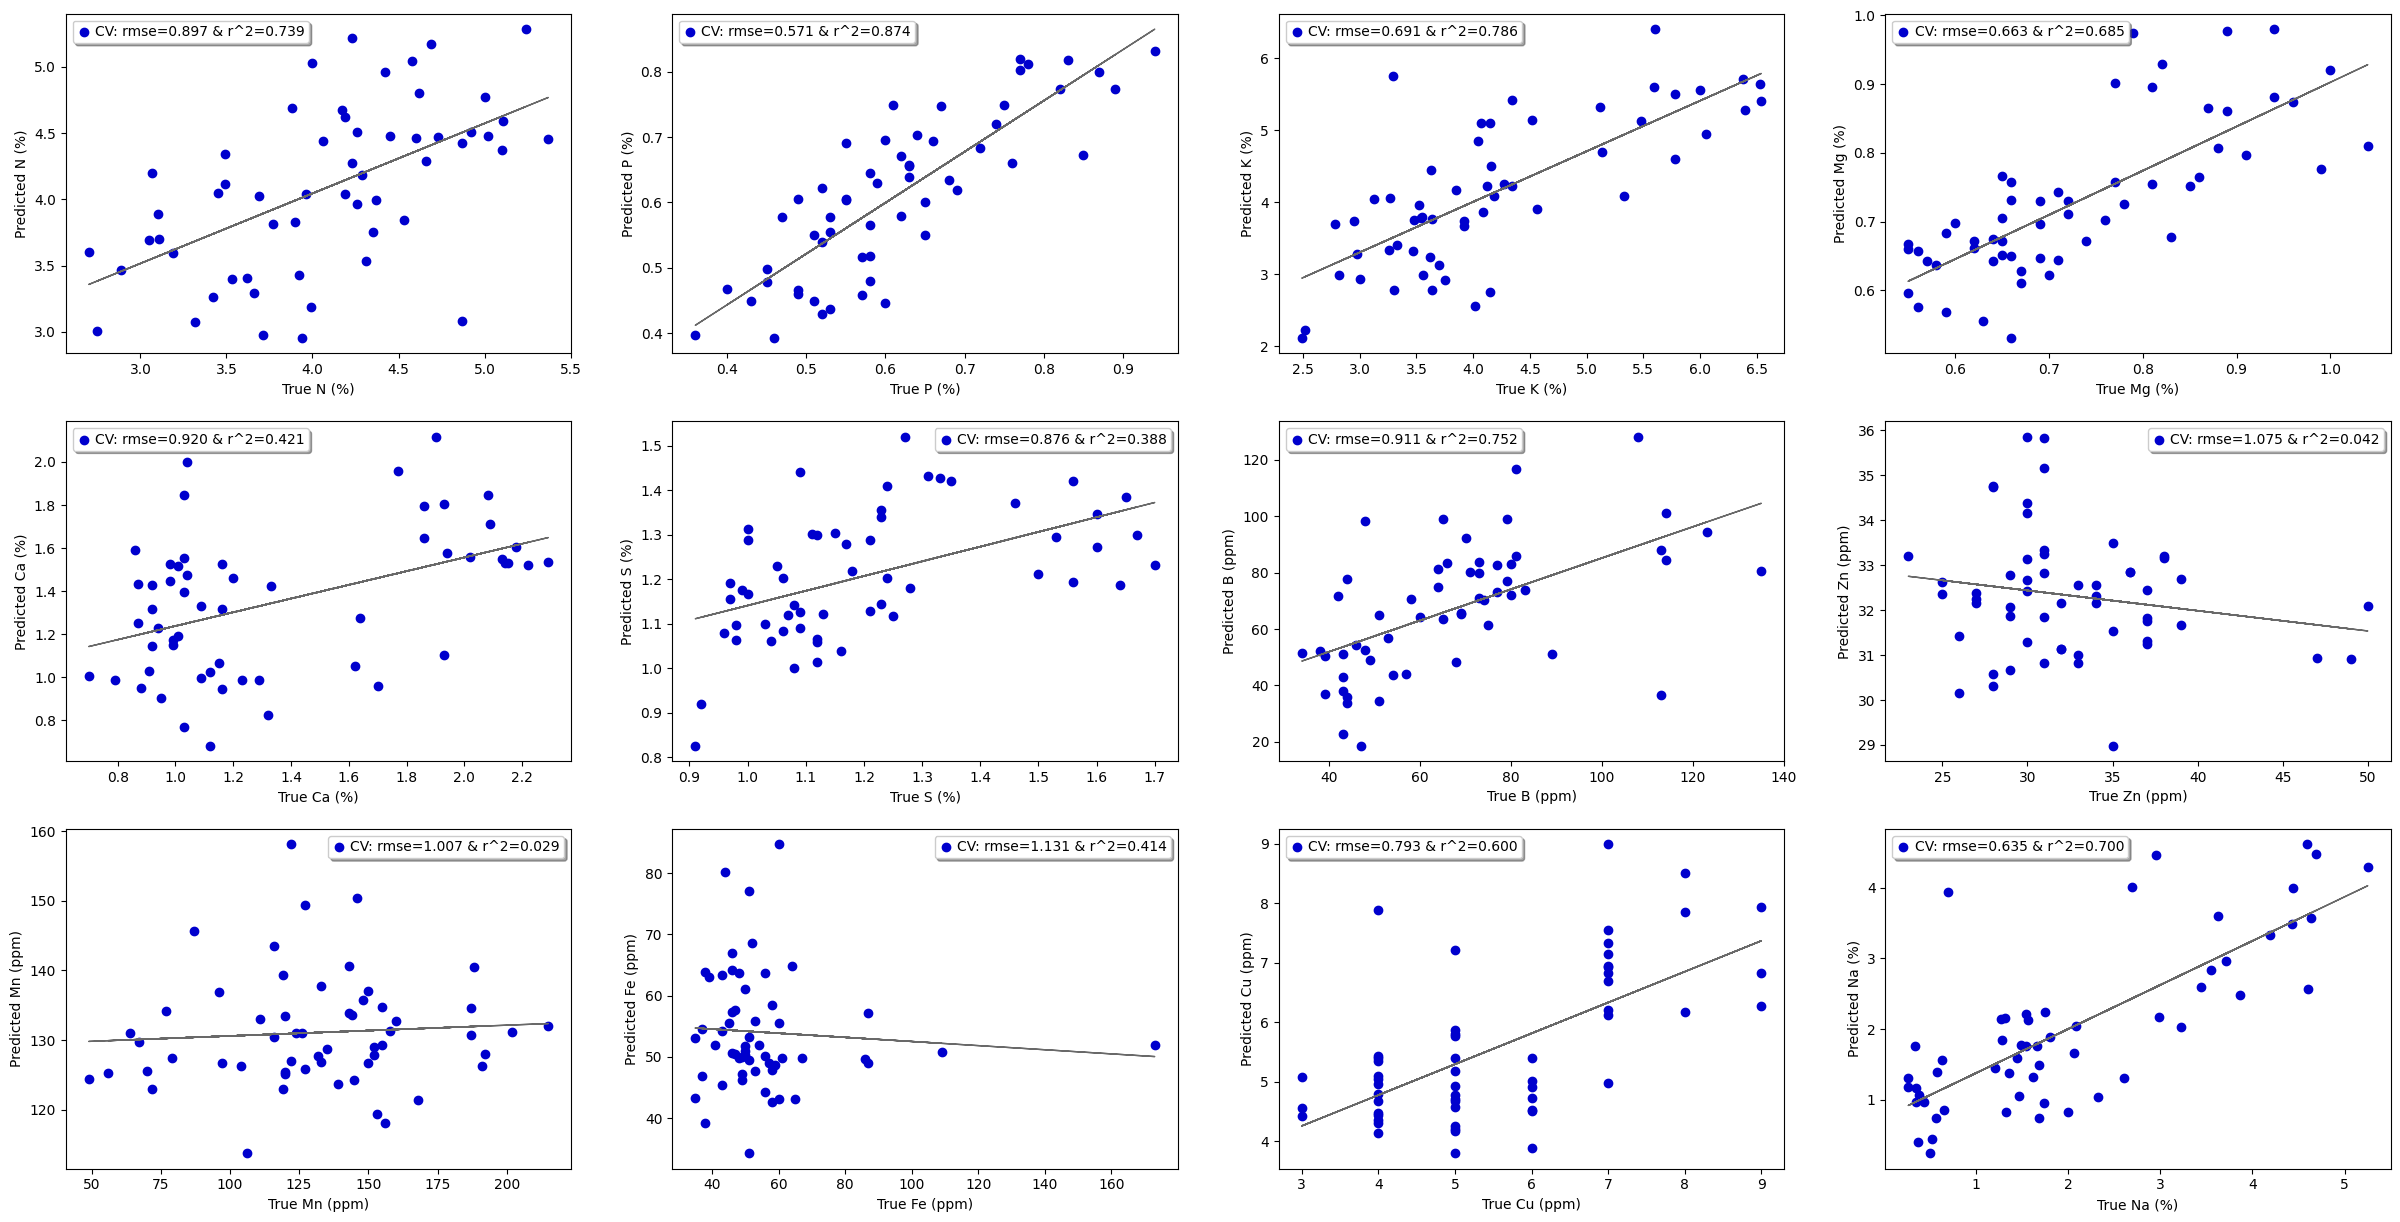

In [90]:
PLSPreScoreRmse1951,PLSPreScoreRs1951,PLSPred1951=pred(PLSModels1951,X1_test,y1_test)
PLSPreScoreRmse,PLSPreScoreRs,PLSPred=pred(PLSModels,X2_test,y2_test)


visualization(y1_train,PLSPreCv1951,y1_test,PLSPred1951,
              PLSCvScoreRmse1951,PLSCvRs1951,
              PLSPreScoreRmse1951,PLSPreScoreRs1951,scalers_1)

In [76]:
#datafram with cv
dfcv1=pd.DataFrame.from_dict(PLSPreCv1951['N (%)'])
# y=PLSModels1951['N (%)'].predict(X1_test)
dfcv2=pd.DataFrame.from_dict(y1_train['N (%)'])
# df1[0]=y
dfcv2.reset_index(drop=True, inplace=True)
dfcv=pd.concat([dfcv1,dfcv2],axis=1)
dfcv[0]=scalers_1["N (%)"].inverse_transform(dfcv[0].values.reshape(-1,1))
dfcv["N (%)"]=scalers_1["N (%)"].inverse_transform(dfcv["N (%)"].values.reshape(-1,1))
# PLSModels1951['N (%)'].score(X1_test,df.iloc[:,1].values.reshape(-1,1))
# r2_score(dfcv["N (%)"],dfcv[0])


In [47]:
#dataframe with no cv

df1=pd.DataFrame.from_dict(PLSPreCv1951['N (%)'])
df2=pd.DataFrame.from_dict(y1_train['N (%)'])
df2.reset_index(drop=True, inplace=True)
df=pd.concat([df1,df2],axis=1)
PLSModels1951['N (%)'].score(X1_train,df2.iloc[:,0].values.reshape(-1,1))

# df[0]=scalers_1["N (%)"].inverse_transform(df[0].values.reshape(-1,1))
# df["N (%)"]=scalers_1["N (%)"].inverse_transform(df["N (%)"].values.reshape(-1,1))
# r2_score(df["N (%)"],df[0])

0.5027946584263794

In [84]:
#datafram for test
dfp=pd.DataFrame.from_dict(y1_test['Ca (%)'])
dfp.columns=['Pred']
y=PLSModels1951['Ca (%)'].predict(X1_test)
dfp['Pred']=y
dft=pd.DataFrame.from_dict(y1_test['Ca (%)'])
dft.reset_index(drop=True, inplace=True)
dfp.reset_index(drop=True, inplace=True)
dfpre=pd.concat([dft,dfp],axis=1)
PLSModels1951['Ca (%)'].score(X1_test,dfpre.iloc[:,0].values.reshape(-1,1))


# dfpre['Pred']=scalers_1["Ca (%)"].inverse_transform(dfpre["Pred"].values.reshape(-1,1))
# dfpre["Ca (%)"]=scalers_1["Ca (%)"].inverse_transform(dfpre["Ca (%)"].values.reshape(-1,1))
# # r2_score(dfpre["N (%)"],dfpre["Pred"])


0.22610067899352615

In [50]:
PLSModels1951['N (%)'].intercept_,PLSModels1951['N (%)'].coef_

C:\tools\Anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


(array([-3.31084366e-16]),
 array([[ 0.00061888],
        [ 0.00054023],
        [ 0.00037214],
        ...,
        [-0.0001195 ],
        [-0.00068803],
        [-0.00088245]]))

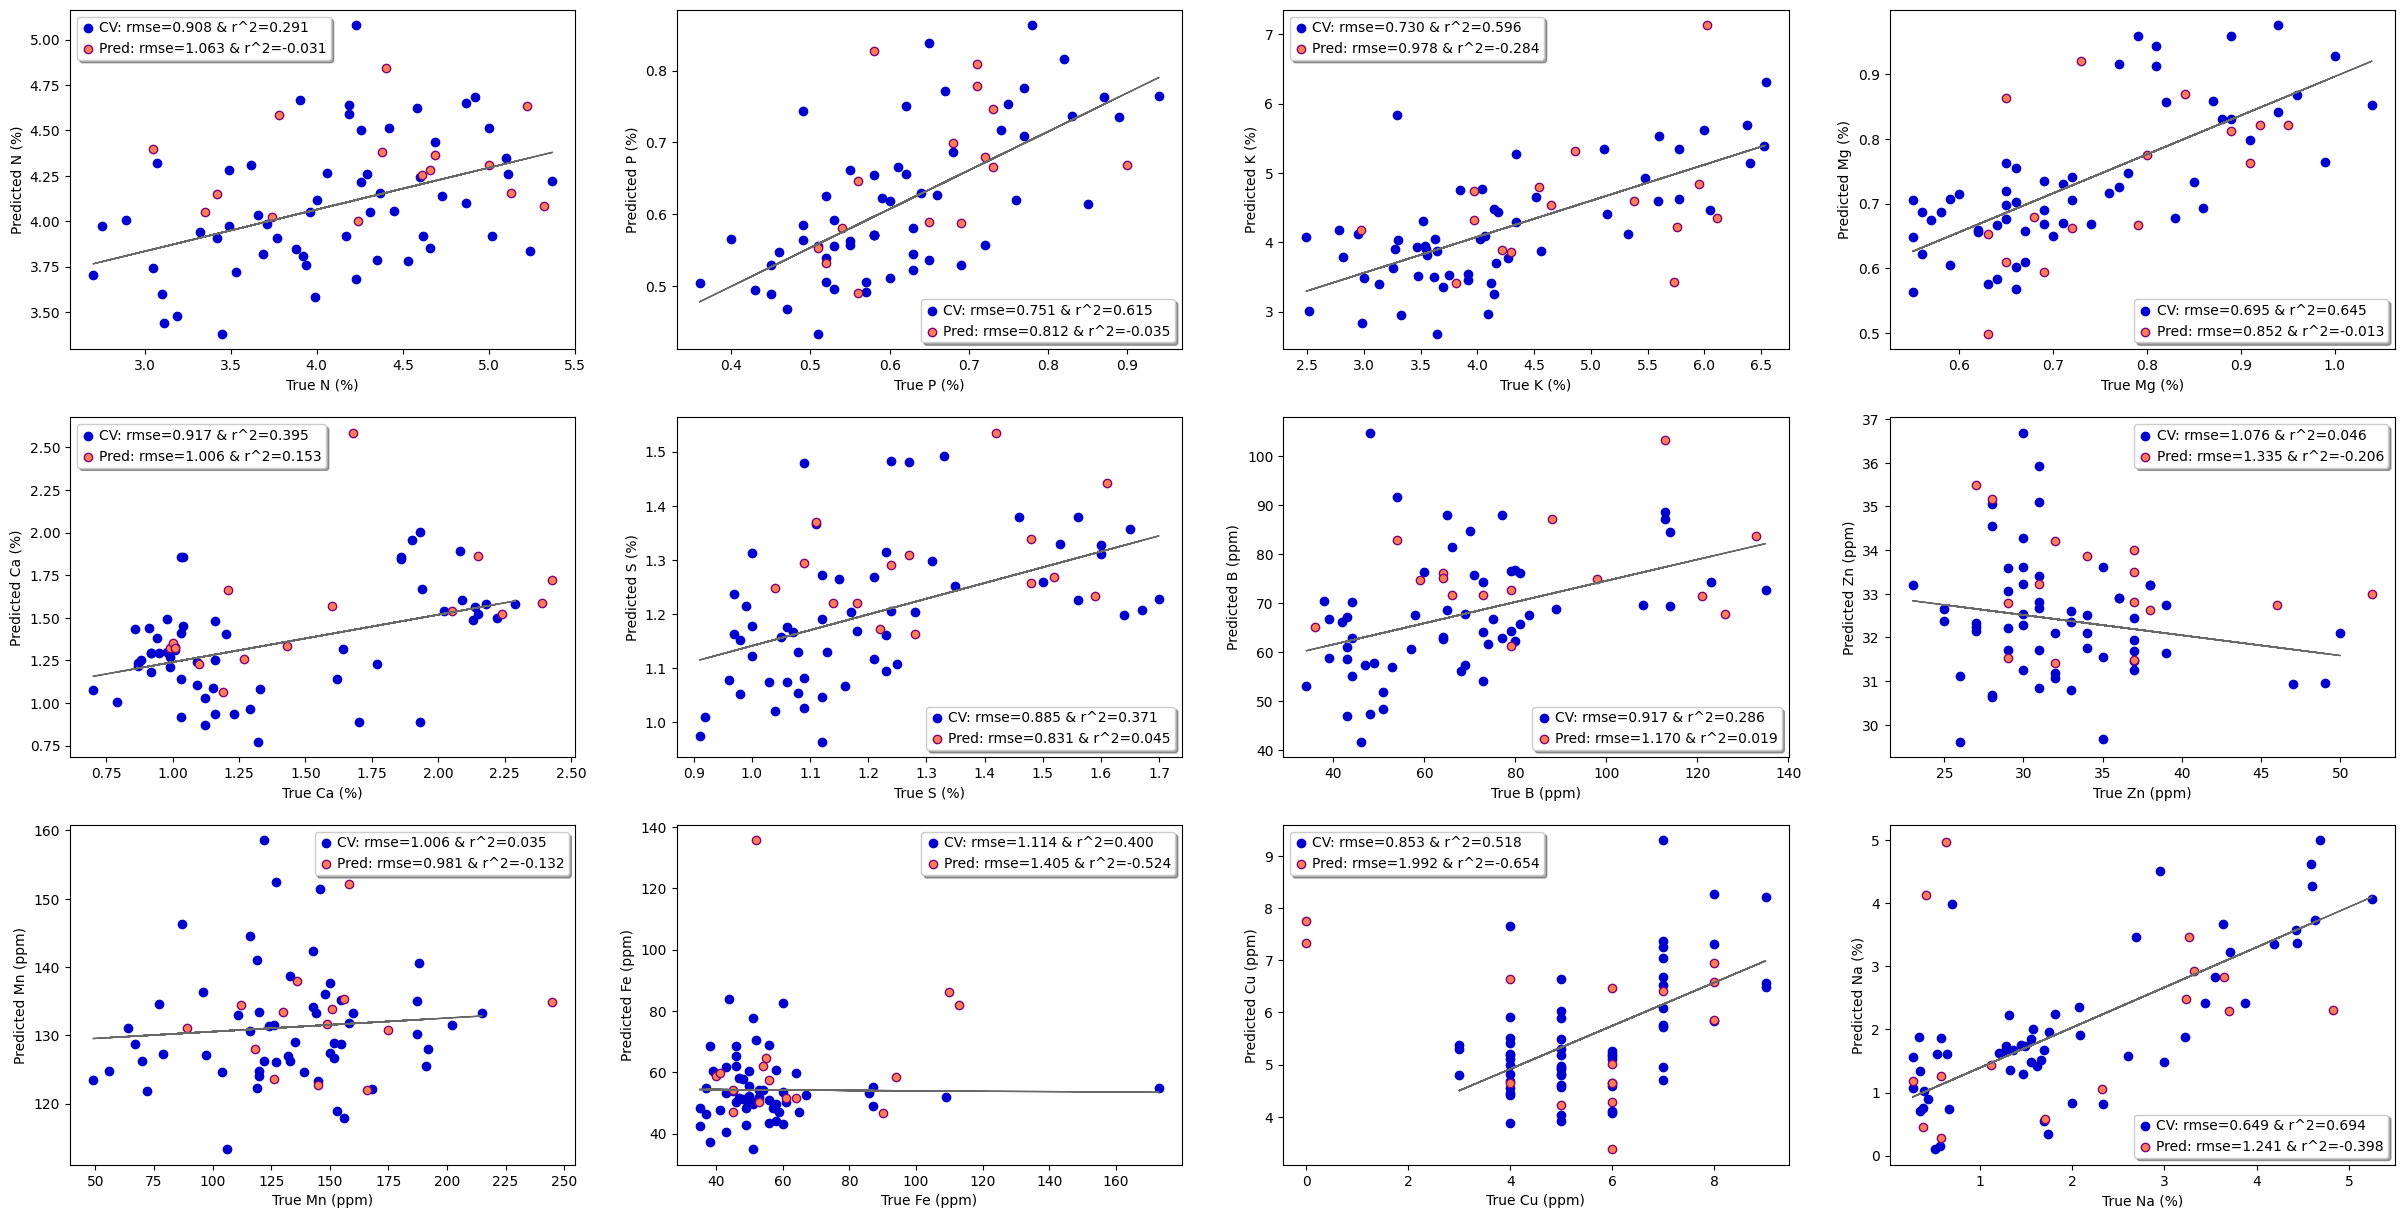

In [26]:
visualization(y2_train,PLSPreCv,y2_test,PLSPred,
              PLSCvScoreRmse,PLSCvRs,
              PLSPreScoreRmse,PLSPreScoreRs,scalers_2)

### Support vector regression

In [37]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [38]:
#helper function
def svr(model,dfx,dftarget):
    scores_rmse={}
    scores_rs={}
    pred={}
    x=dfx.values
    models={}
    for target in dftarget.columns:
        models[target]=model
        models[target].fit(x,dftarget[target])
        cv_pred[target]=cross_val_predict(models[target],x,dftarget[target],cv=5)
        scores_rmse_cv[target]=mean_squared_error(dftarget[target].values, pred[target],squared=False)
        scores_rs_cv[target]=models[target].score(dftarget[target].values, pred[target])

    return scores_rmse_cv,scores_rs_cv,cv_pred, models

In [39]:
para={'C':[0.01,0.1,1,10,15,100],'gamma':[0.1,0.001,0.01,1],'kernel':['rbf']}
random_search = RandomizedSearchCV(SVR(),para,n_iter=1000,cv=5,scoring=scorer,n_jobs=-1)
random_search.fit(X1_train,y1_train['Na (%)'])
print(random_search.best_estimator_)
print(random_search.best_score_)

C:\tools\Anaconda3\envs\tf-gpu2\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 24 is smaller than n_iter=1000. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVR(C=100, gamma=0.01)
-0.4394534003103988


In [60]:
SvrCvScoreRmse1951,SvrCvRs1951,SvrPreCv1951,SvrModels1951=svr(SVR(C=15,gamma=0.03,kernel='rbf'),X1_train,y1_train)
SvrCvScoreRmse,SvrCvRs,SvrPreCv,SvrModels=svr(SVR(C=10,kernel='linear'),X2_train,y2_train)

#prediction
SvrPreScoreRmse1951,SvrPreScoreRs1951,SvrPred1951=pred(SvrModels1951,X1_test,y1_test)
SvrPreScoreRmse,SvrPreScoreRs,SvrPred=pred(SvrModels,X2_test,y2_test)

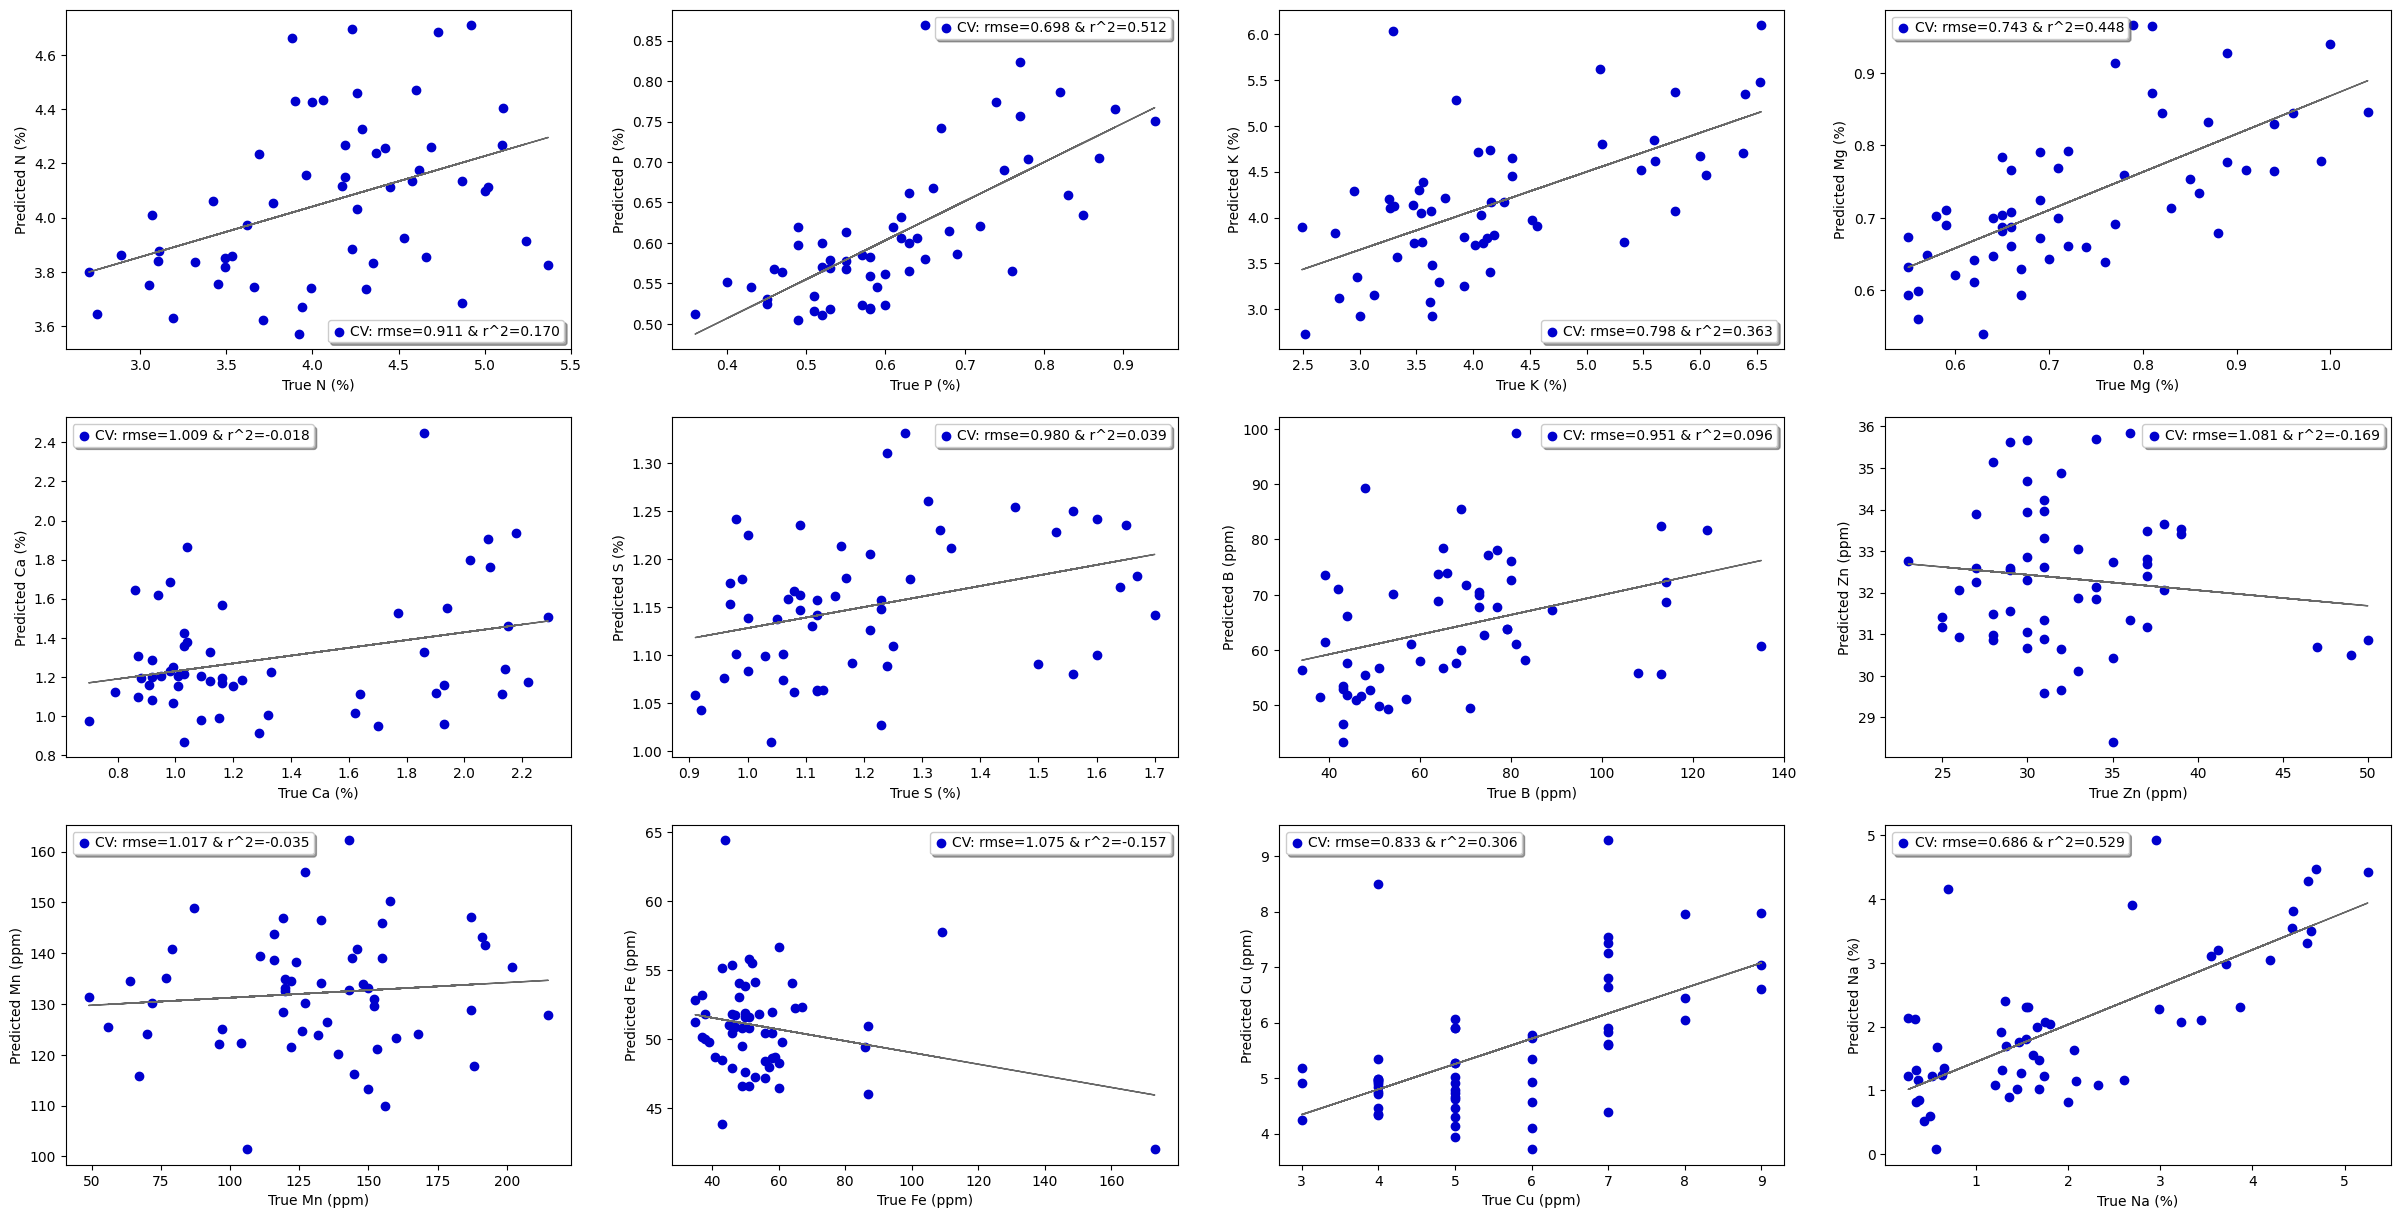

In [61]:
visualization(y1_train,SvrPreCv1951,y1_test,SvrPred1951,
              SvrCvScoreRmse1951,SvrCvRs1951,
              SvrPreScoreRmse1951,SvrPreScoreRs1951,scalers_1)

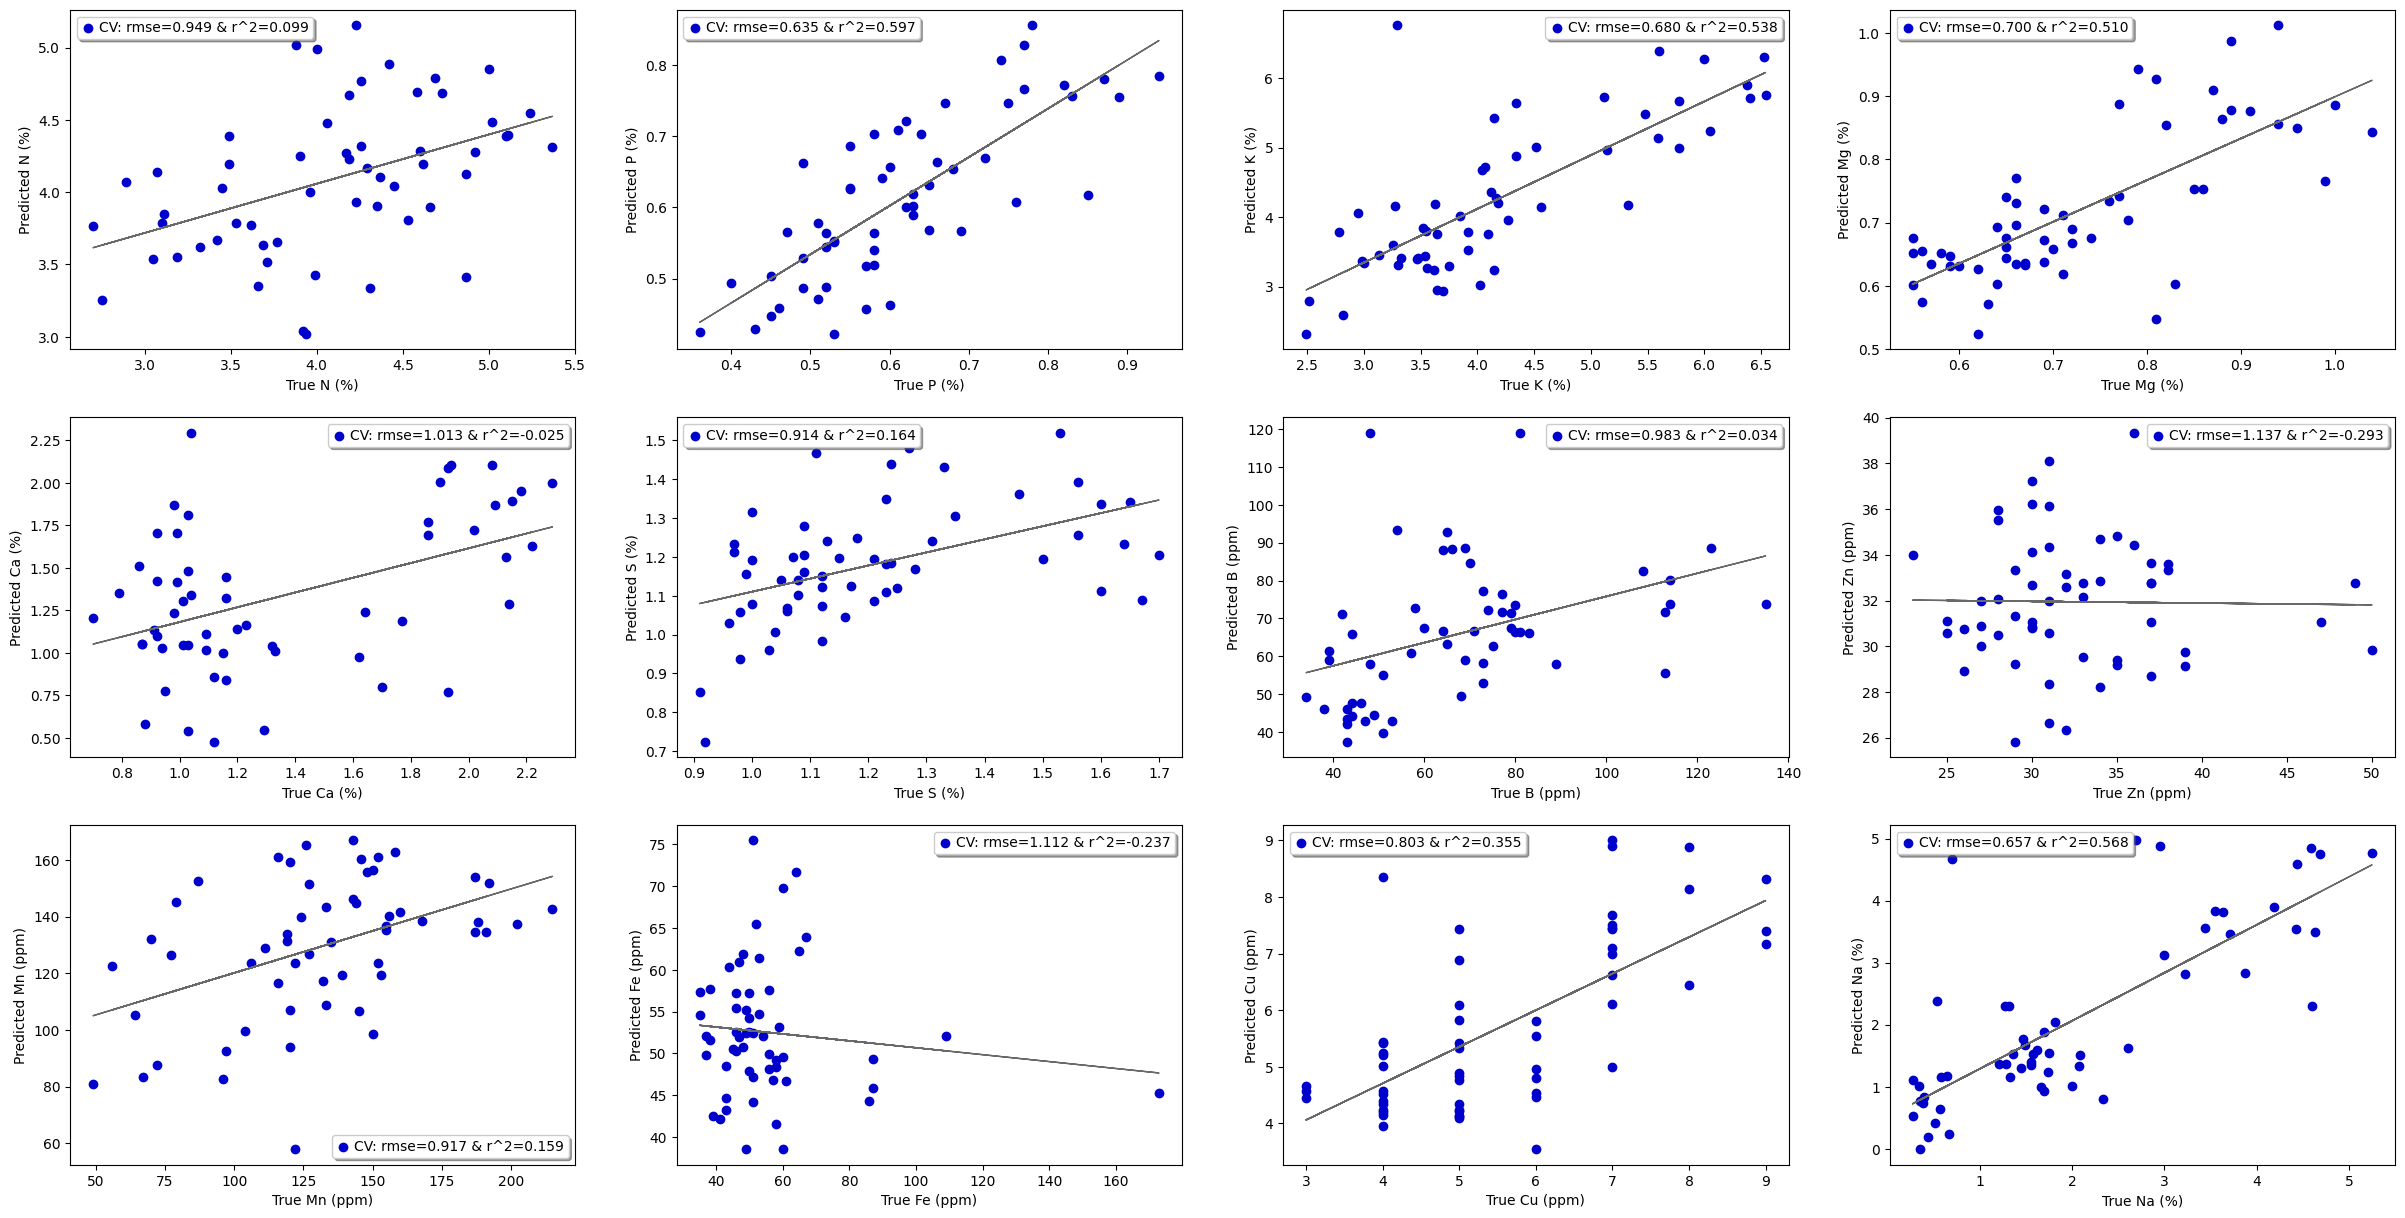

In [40]:
visualization(y2_train,SvrPreCv,y2_test,SvrPred,
              SvrCvScoreRmse,SvrCvRs,
              SvrPreScoreRmse,SvrPreScoreRs,scalers_2)

### PCR

In [62]:
from sklearn.decomposition import PCA

In [63]:
def pca(data):
    pca=PCA(n_components=0.95)
    pca.fit(data)
    return pca.transform(data)

In [64]:
X1p_train, X1p_test, y1p_train, y1p_test = train_test_split(
...     pca(xs_train_1951), standardGT, test_size=0.2, random_state=42)

X2p_train, X2p_test, y2p_train, y2p_test = train_test_split(
...     pca(x_train_whole), standardGT, test_size=0.2, random_state=42)

PCRCvScoreRmse1951,PCRCvRs1951,PCRPreCv1951,PCRModels1951=lr(X1p_train,y1p_train)
PCRCvScoreRmse,PCRCvRs,PCRPreCv,PCRModels=lr(X2p_train,y2p_train)

PCRPreScoreRmse1951,PCRPreScoreRs1951,PCRPred1951=pred(PCRModels1951,X1p_test,y1p_test)
PCRPreScoreRmse,PCRPreScoreRs,PCRPred=pred(PCRModels,X2p_test,y2p_test)

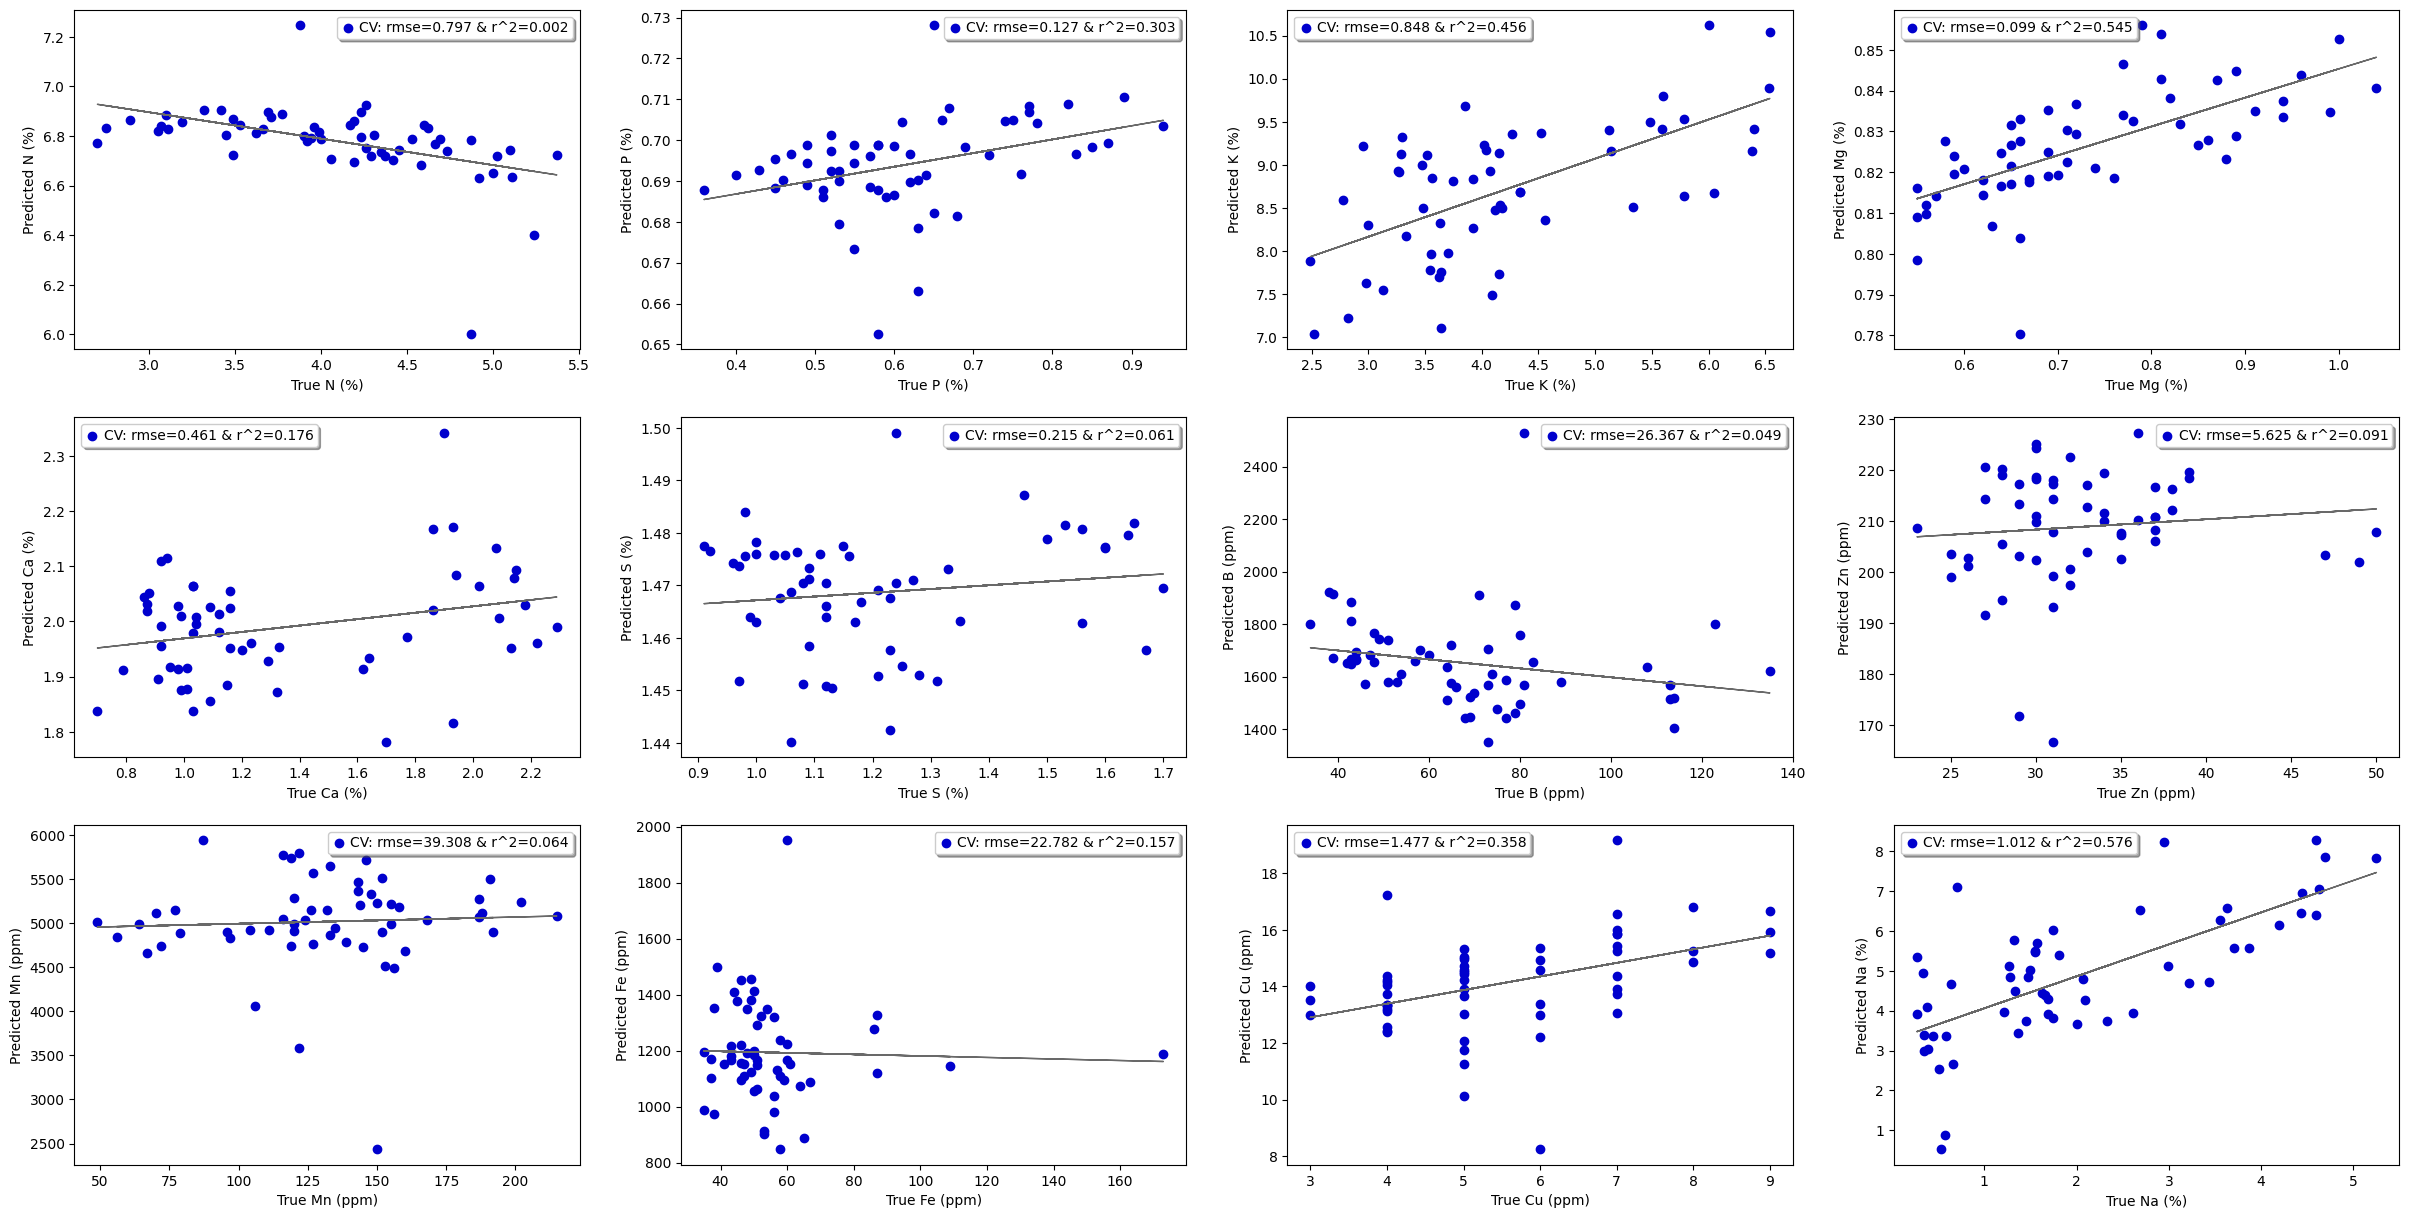

In [65]:
visualization(y1_train,PCRPreCv1951,y1_test,PCRPred1951,
              PCRCvScoreRmse1951,PCRCvRs1951,
              PCRPreScoreRmse1951,PCRPreScoreRs1951,scalers_1)

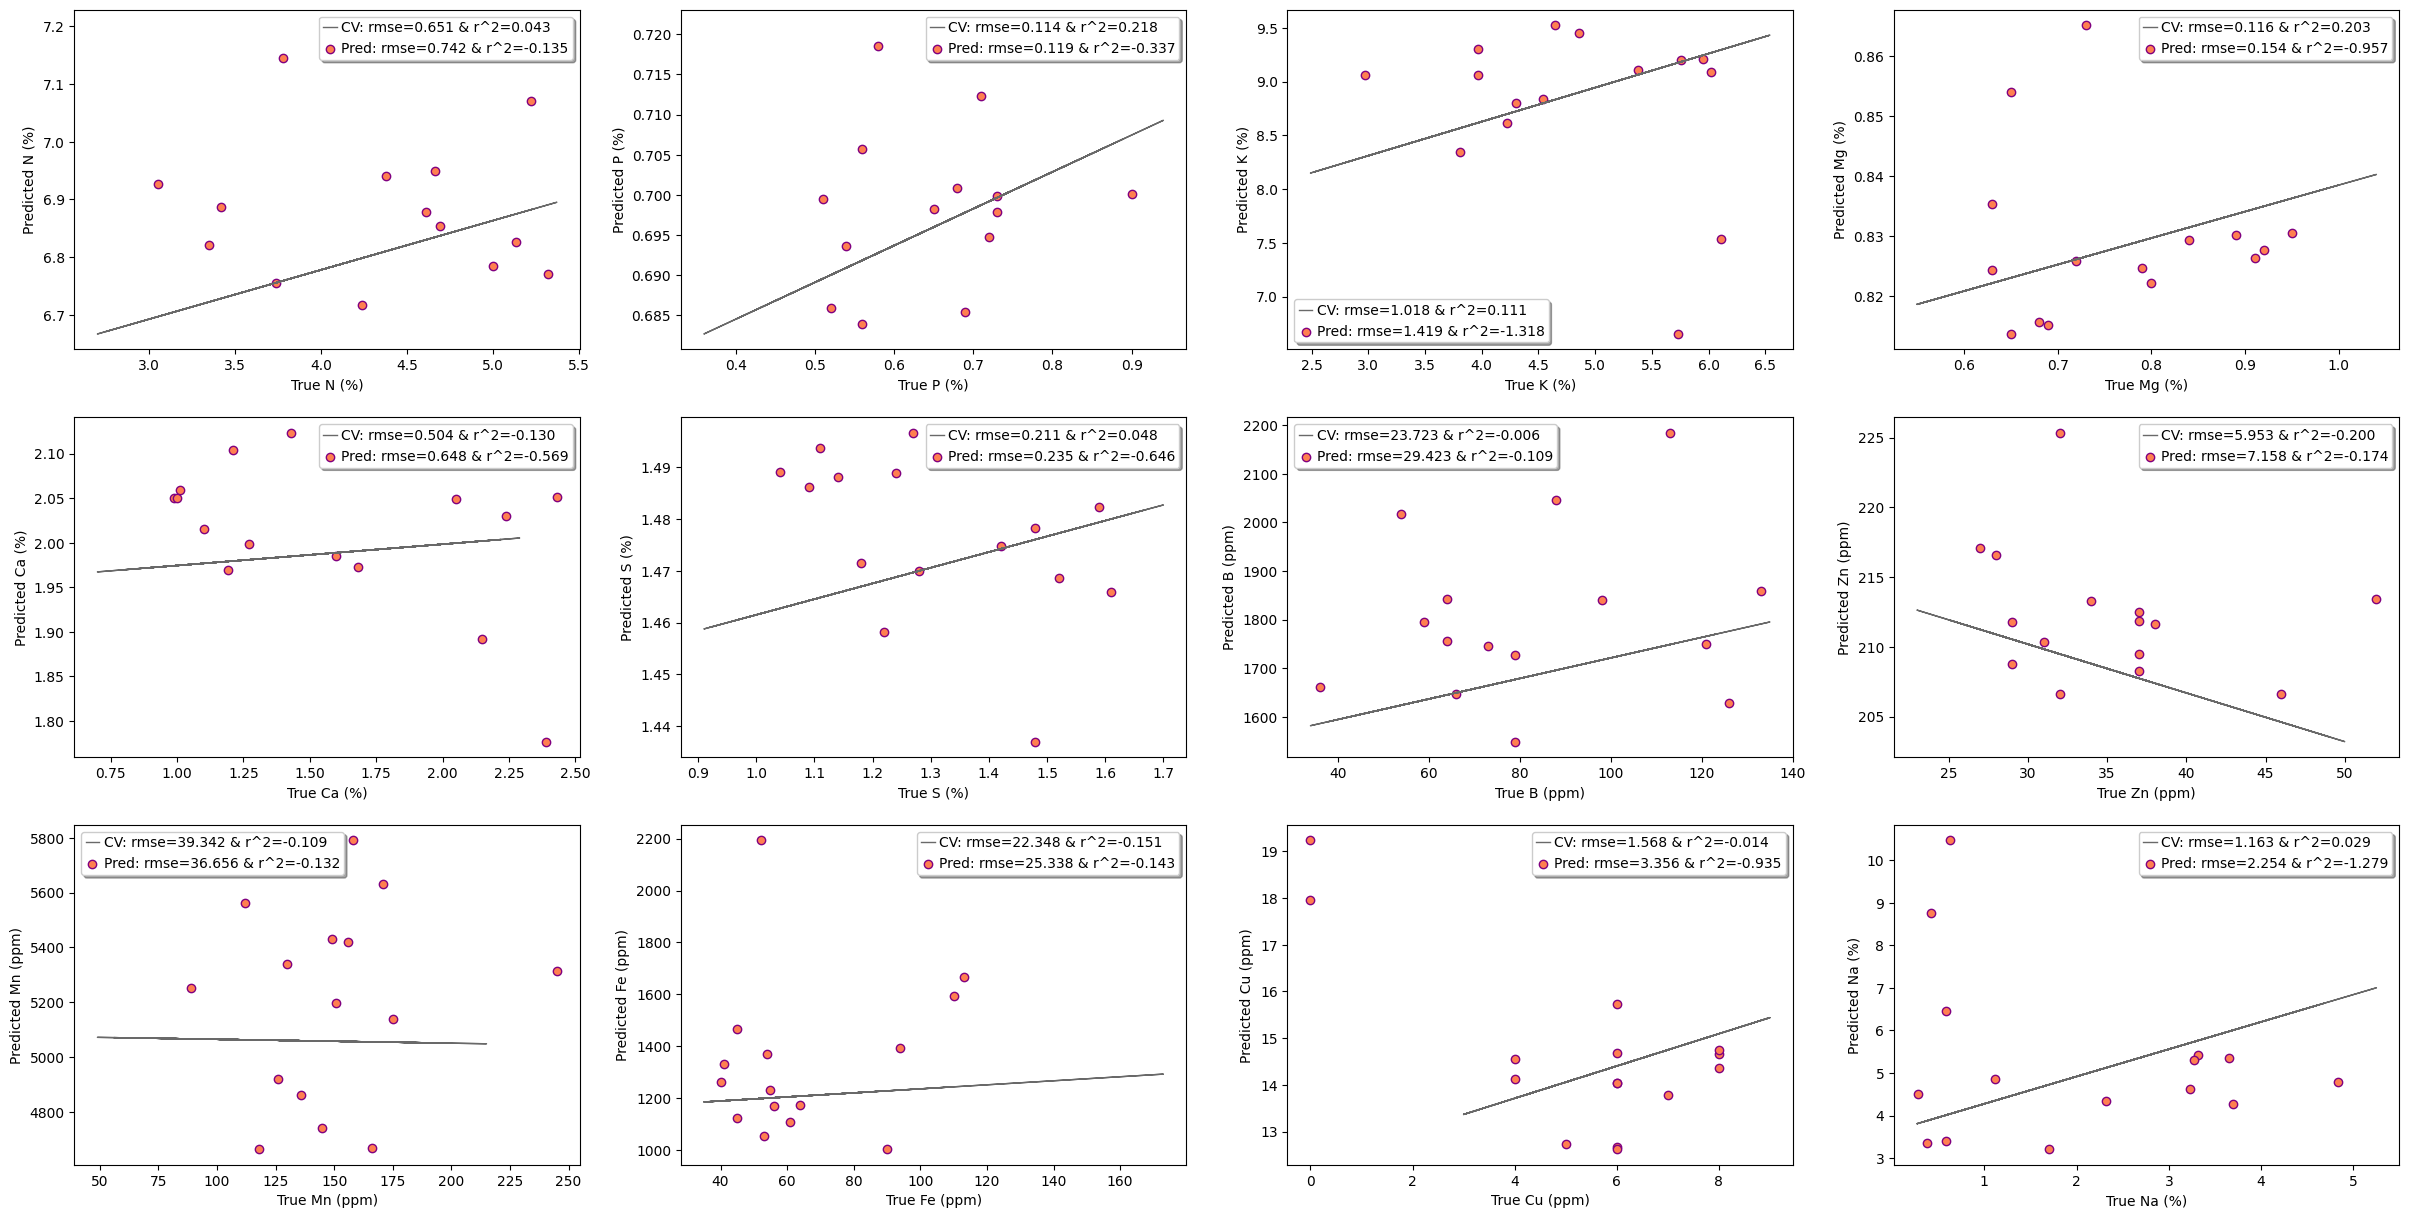

In [55]:
visualization(y2_train,PCRPreCv,y2_test,PCRPred,
              PCRCvScoreRmse,PCRCvRs,
              PCRPreScoreRmse,PCRPreScoreRs,scalers_1)

### Random forest

In [66]:
from sklearn.ensemble import RandomForestRegressor
import shap

C:\tools\Anaconda3\envs\tf-gpu2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
def rf(dfx,dftarget):

    pred={}
    scores_rmse={}
    scores_rs={}
    x=dfx.values
    models={}
    for target in dftarget.columns:
        models[target]=RandomForestRegressor(n_estimators =800,max_depth=2,random_state = 42)
        models[target].fit(x,dftarget[target])
 
        pred[target]=cross_val_predict(models[target],x,dftarget[target],cv=5)
        scores_rmse[target]=mean_squared_error(dftarget[target].values, pred[target],squared=False)
        scores_rs[target]=r2_score(dftarget[target].values, pred[target])
        print(f'Calculation for {target} done')
    models['combine']=RandomForestRegressor(n_estimators =800,max_depth=2,random_state = 42)
    models['combine'].fit(x,dftarget.values)    
    pred['combine']=cross_val_predict(models[target],x,dftarget.values,cv=5)
    scores_rmse['combine']=mean_squared_error(dftarget.values, pred['combine'],squared=False)
    scores_rs['combine']=r2_score(dftarget.values, pred['combine'])
    print('Done..... \n')

    return scores_rmse,scores_rs,pred, models

In [68]:
RfCvScoreRmse1951,RfCvRs1951,RfPreCv1951,RfModels1951=rf(X1_train,y1_train)
RfCvScoreRmse,RfCvRs,RfPreCv,RfModels=rf(X2_train,y2_train)

Calculation for N (%) done
Calculation for P (%) done
Calculation for K (%) done
Calculation for Mg (%) done
Calculation for Ca (%) done
Calculation for S (%) done
Calculation for B (ppm) done
Calculation for Zn (ppm) done
Calculation for Mn (ppm) done
Calculation for Fe (ppm) done
Calculation for Cu (ppm) done
Calculation for Na (%) done
Done..... 

Calculation for N (%) done
Calculation for P (%) done
Calculation for K (%) done
Calculation for Mg (%) done
Calculation for Ca (%) done
Calculation for S (%) done
Calculation for B (ppm) done
Calculation for Zn (ppm) done
Calculation for Mn (ppm) done
Calculation for Fe (ppm) done
Calculation for Cu (ppm) done
Calculation for Na (%) done
Done..... 



In [69]:
RfPreScoreRmse1951,RfPreScoreRs1951,RfPred1951=pred(RfModels1951,X1_test,y1_test)
RfPreScoreRmse,RfPreScoreRs,RfPred=pred(RfModels,X2_test,y2_test)


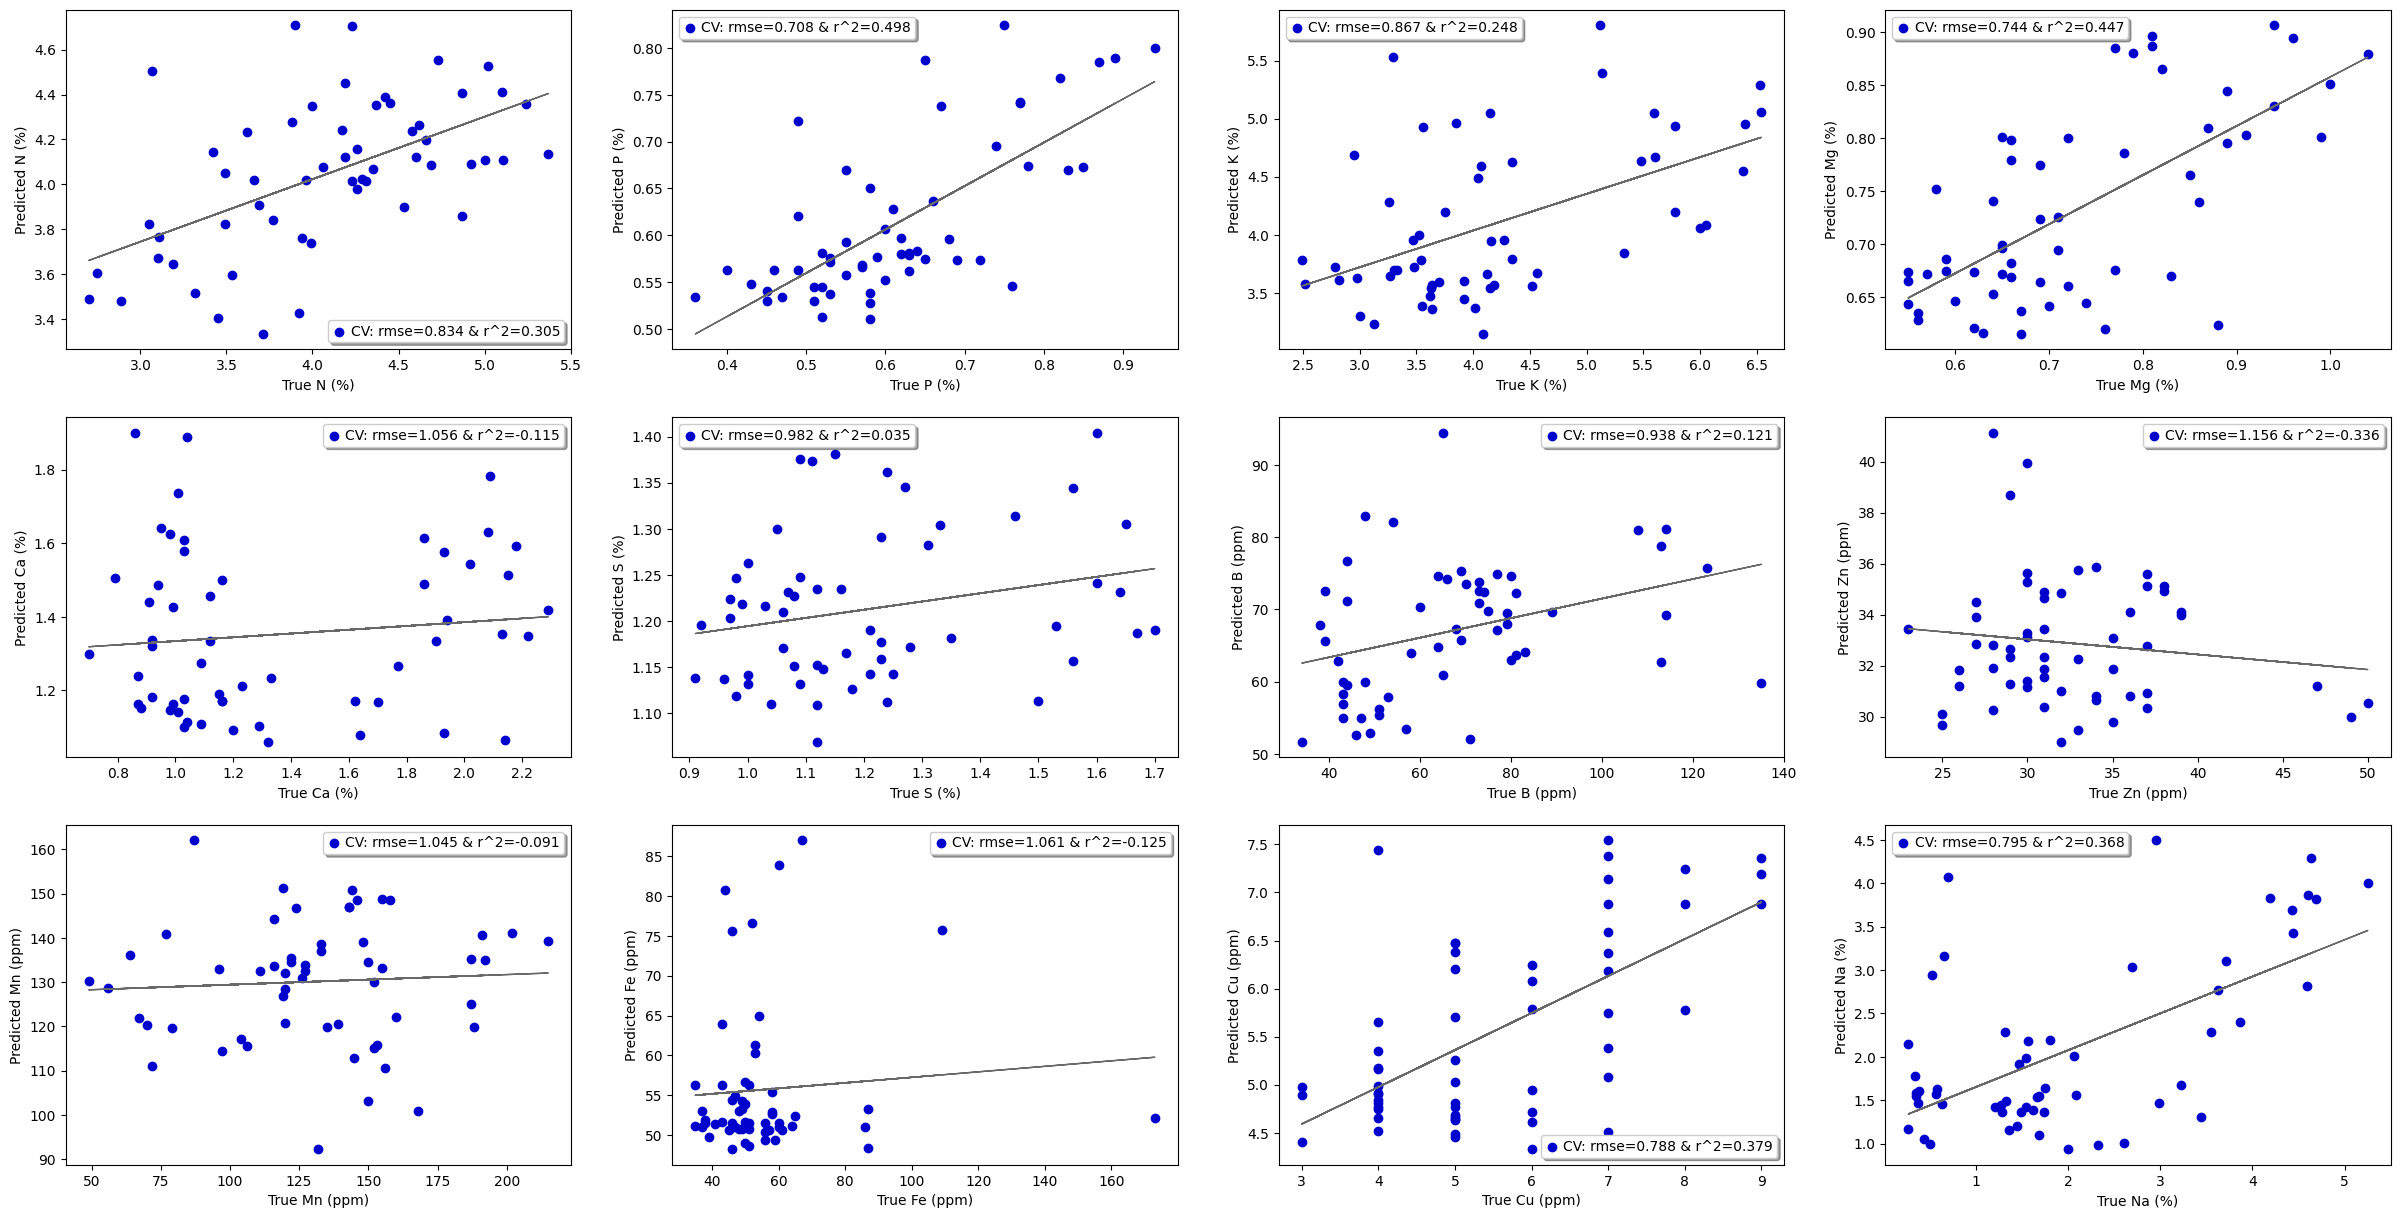

In [71]:
visualization(y1_train,RfPreCv1951,y1_test,RfPred1951,
              RfCvScoreRmse1951,RfCvRs1951,
              RfPreScoreRmse1951,RfPreScoreRs1951,scalers_1)

In [44]:
visualization(y2_train,RfPreCv,y1_test,RfPred,
              RfCvScoreRmse,RfCvRs,
              RfPreScoreRmse,RfPreScoreRs)

NameError: name 'RfCvRs' is not defined

In [ ]:
rf = RandomForestRegressor(n_estimators = 500,max_depth=2,random_state = 42)
rf.fit(X2_train,y2_train)
yhat=rf.predict(X2_test)
mean_squared_error(y2_test,yhat)

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X2_test)
shap.summary_plot(shap_values, X2_test,plot_type="bar")

In [ ]:
#important features for all target value
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X2_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
features=feature_importance.col_name[feature_importance.feature_importance_vals!= 0.000000]

In [ ]:
feature20=feature_importance.col_name[:100]
newx2_20=X2_train.loc[:,feature20]

In [ ]:
newx2=X2_train.loc[:,features]

In [ ]:
rf2 = RandomForestRegressor(n_estimators = 1000,max_depth=2,random_state = 42)
rf2.fit(newx2,y2_train)

yhat=rf2.predict(X2_test.loc[:,features])
mean_squared_error(y2_test,yhat)

In [ ]:
rf3 = RandomForestRegressor(n_estimators = 1000, max_features=newx2_20.shape[1]//3,max_depth=2,random_state = 42)
rf3.fit(newx2_20,y2_train)

yhat=rf3.predict(X2_test.loc[:,feature20])
mean_squared_error(y2_test,yhat)

In [ ]:

di={}
for i,target in enumerate(y2_test.columns):
    vals=np.abs(shap_values[i].mean(0))
    feature_importance = pd.DataFrame(list(zip(X2_train.columns, vals)), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    di[target]=feature_importance['col_name'].values
pd.DataFrame.from_dict(di)